In [1]:
# Load packages
import sys
import os
import glob

import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt

from scipy import interpolate
from scipy.interpolate import InterpolatedUnivariateSpline
from scipy import stats 
from scipy.optimize import curve_fit 

import FunctionsP6 as fc

import sklearn
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

import dask.config as dc
dc.set(**{'array.slicing.split_large_chunks': True});

import warnings
warnings.filterwarnings('ignore')

dpi=200

In [41]:
savepath=os.getcwd() + '/Figures_new/'

In [7]:
import statsmodels.api as sm # to build a LOWESS model
from scipy.interpolate import interp1d # for interpolation of new data points
lowess = sm.nonparametric.lowess

In [8]:
def CMIP_LOWESS(ds, window, mip):
    frac = window/ds.time.values.shape[0]


    mods = ds.model.values
    sces = ['ssp126', 'ssp245', 'ssp585']

    LF_data_zos = [[],[],[]]
    LF_data_zostoga = [[],[],[]]
    LF_data_GSAT = [[],[],[]]
    LF_data_AMOC26 = [[],[],[]]
    LF_data_AMOC35 = [[],[],[]]
    # Loop over scenario, model, variable:
    for i, scen in enumerate(['ssp126','ssp245','ssp585']):
        
        #for variab in enumerate['zos','zostoga','GSAT','AMOC26']:
            
        for mod in mods:

            LF_data_zos[i].append(lowess(ds.sel(scenario=scen, model=mod)['zos'].values, 
                                         ds['time'].values, frac, return_sorted=False))
            LF_data_GSAT[i].append(lowess(ds.sel(scenario=scen, model=mod)['GSAT'].values, 
                           ds['time'].values, frac, return_sorted=False))
            LF_data_zostoga[i].append(lowess(ds.sel(scenario=scen, model=mod)['zostoga'].values, 
                           ds['time'].values, frac, return_sorted=False))
                
            if mip == 'cmip6':    
                LF_data_AMOC26[i].append(lowess(ds.sel(scenario=scen, model=mod)['AMOC26'].values, 
                               ds['time'].values, frac, return_sorted=False))
                LF_data_AMOC35[i].append(lowess(ds.sel(scenario=scen, model=mod)['AMOC35'].values, 
                               ds['time'].values, frac, return_sorted=False))
    
    
    # Store arrays in ds

    if mip == 'cmip5':
        ds_LOWESS = xr.Dataset(
            data_vars=dict(
                zos=(["scenario", "model" , "time"], LF_data_zos),
                zostoga=(["scenario","model" , "time"], LF_data_zostoga),
                GSAT=(["scenario","model" , "time"], LF_data_GSAT)
            ),
            coords=dict(
                model=(["model"], mods),
                scenario=(["scenario"], sces),
                time =(["time"],ds['time'].values)
            ),
                attrs=dict(description="CMIP5 dataset - LOWESS FILTER - with variables dynamic sea-level (zos), \
                           global mean steric sea-level (zostoga), and global surface air temperature (GSAT)"),
            )
        
    if mip == 'cmip6':
        ds_LOWESS = xr.Dataset(
            data_vars=dict(
                zos=(["scenario", "model" , "time"], LF_data_zos),
                zostoga=(["scenario","model" , "time"], LF_data_zostoga),
                GSAT=(["scenario","model" , "time"], LF_data_GSAT),
                AMOC26=(["scenario","model" , "time"], LF_data_AMOC26),
                AMOC35=(["scenario","model" , "time"], LF_data_AMOC35)
            ),
            coords=dict(
                model=(["model"], mods),
                scenario=(["scenario"], sces),
                time =(["time"],ds['time'].values)
            ),
                attrs=dict(description="CMIP6 dataset - LOWESS FILTER - with variables dynamic sea-level (zos), \
                global mean steric sea-level (zostoga), and global surface air temperature (GSAT), \
                AMOC strength at 26 degrees (AMOC26) and at 35 degrees (AMOC35)"),
            )
    return ds_LOWESS
            

In [9]:
'''
We load the data that is prepared in 'M2_DataPrep'
'''
# GSAT, zostoga observations (1900 - 2005) merged with AR6 ranges for all scenarios (2005 - 2100) 
df_low = pd.read_csv(os.getcwd() + '/data_processed/AR6_obs17_low_perc.csv').set_index('Date')
df_mid = pd.read_csv(os.getcwd() + '/data_processed/AR6_obs17_mid_perc.csv').set_index('Date')
df_hig = pd.read_csv(os.getcwd() + '/data_processed/AR6_obs17_hig_perc.csv').set_index('Date')

# CMIP5 and CMIP6 data (1900 - 2100)
CMIP5ds = xr.open_mfdataset(os.getcwd()+'/data_processed/ds_CMIP5.nc')
CMIP6ds = xr.open_mfdataset(os.getcwd()+'/data_processed/ds_CMIP6.nc')

# DSL budgets / reanalysis (ora20c)
df_dsl_b1 = pd.read_csv(os.getcwd() + '/data_processed/DSL_b1.csv' ).set_index('time') # (1979 - 2018)
df_dsl_b2 = pd.read_csv(os.getcwd() + '/data_processed/DSL_b2.csv' ).set_index('time') # (1950 - 2020)

# Reanalysis (1905 - 2005) (1990-1994 and 2006-2009 is nan)
ds_dsl_ora20c = xr.open_mfdataset(os.getcwd()+'/data_processed/DSL_ora20c.nc') # 1900 - 2009

In [10]:
# Change ref - OPTIONAL
ref_st, ref_end = 1900,1950

for dfs in [df_low, df_mid, df_hig]:
    dfs.iloc[:,0:3] = dfs.iloc[:,0:3] - dfs.loc[ref_st:ref_end].mean()[1]
    dfs.iloc[:,3:6] = dfs.iloc[:,3:6] - dfs.loc[ref_st:ref_end].mean()[4]
#df_low = df_low - df_low.loc[ref_st:ref_end-1].mean()
#df_mid = df_mid - df_mid.loc[ref_st:ref_end-1].mean()
#df_hig = df_hig - df_hig.loc[ref_st:ref_end-1].mean()

CMIP5ds = CMIP5ds - CMIP5ds.sel(time=slice(ref_st,ref_end)).mean(dim='time')
CMIP6ds = CMIP6ds - CMIP6ds.sel(time=slice(ref_st,ref_end)).mean(dim='time')

ds_dsl_ora20c = ds_dsl_ora20c-np.nanmean(ds_dsl_ora20c.sel(year=slice(ref_st,ref_end)).median(dim='member').zos.values)#mean(dim='year')

In [33]:
CMIP5ds_new = CMIP5ds.sel(time=slice(1900,2100))
LF_5 = CMIP_LOWESS(CMIP5ds_new, 20, 'cmip5')

CMIP6ds_new = CMIP6ds.sel(time=slice(1900,2100))
LF_6 = CMIP_LOWESS(CMIP6ds_new, 20, 'cmip6')

LF_5 = LF_5 - LF_5.sel(time=slice(ref_st,ref_end)).mean(dim='time')
LF_6 = LF_6 - LF_6.sel(time=slice(ref_st,ref_end)).mean(dim='time')


In [25]:
def select_models(ds, varx1, vary, check):
    '''
    Check is either 'model', or 'scenario'
    Find models for which all three variables (zos, gsat, zostoga) are available
    Input is dataset CMIP5ds or CMIP6ds. 
    If you want to check the scenarios per model, already select the model in the input: eg. CMIP5ds.sel(model=mod)
    It returns the model/sce names of models/sces that have data for all three variables and returns the new dataset.
    '''
    
    x1 = ds[varx1].dropna(check,'all')[check].values
    y = ds[vary].dropna(check,'all')[check].values
        
    check_list = np.sort(list(set(x1)&set(y)))
    
    if check == 'model':
        ds_new = ds.sel(model=check_list)
        
    elif check == 'scenario':
        ds_new = ds.sel(scenario=check_list)
    
    return check_list, ds_new

In [26]:
#%% Multi-linear regression
def lin_reg_multi(varx, vary):
    regr = linear_model.LinearRegression()

    varx = varx.dropna()
    vary = vary.dropna()

    regr.fit(varx, vary)
    
    vary_pred = regr.predict(varx)

    mse = mean_squared_error(vary, vary_pred)
    r2 = r2_score(vary, vary_pred)
    slope = regr.coef_
    intercept = regr.intercept_
    
    return vary_pred, mse, r2, slope, intercept

varx = 'GSAT'
newmip5 = select_models(CMIP5ds.sel(scenario='ssp245'), varx, 'zos', 'model')[1]
newmip6 = select_models(CMIP6ds.sel(scenario='ssp245'), varx, 'zos', 'model')[1]

In [27]:
def lin_fit(ds, varx):    
    ds_new = select_models(ds, varx, 'zos', 'model')[1]
    #ds_new = select_models(ds_new,'AMOC26','zos','model')[1]
    
    nan_array_sce = np.ones(95)*np.nan
    mods, sces = [],[]
    dfs = []
    mses, r2s, slope_varx, intercepts = [],[],[],[]
    
    for j, mod in enumerate(ds_new.model.values):
        
        if mod == 'GFDL-CM3':
            pass 
        else:
            sces_in_mod = select_models(ds_new.sel(model=mod), varx, 'zos', 'scenario')[0]
            #print(sces_in_mod)
            ds_mod = ds_new.sel(model=mod)
            mods.append(mod)           # append model name
            sces.append(sces_in_mod)   # append scenarios available for this model
        
            ds_hist = ds_mod.sel(time=slice(1900,2005),scenario=sces_in_mod[0])  # select historical period for one sce
            ds_sces = ds_mod.sel(time=slice(2005,2100))                          # select future period for all sces

            DSL_mod, varx_mod = ds_hist.zos.values, ds_hist[varx].values      
        
            for sce in ['ssp126','ssp245','ssp585']:        
                ds_sce = ds_sces.sel(scenario=sce)
            
                zos = ds_sce.zos.values
                varx_list = ds_sce[varx].values
            
                if(np.isnan(zos).any()) or (np.isnan(varx_list).any()):
                    DSL_mod = np.append(DSL_mod, np.ones(95)*np.nan)
                    varx_mod = np.append(varx_mod, np.ones(95)*np.nan)
                else:
                    DSL_mod = np.append(DSL_mod, zos)
                    varx_mod = np.append(varx_mod, varx_list)
            
            # Store total data in dataframe for each model
            d = {'DSL': DSL_mod, 'varx': varx_mod}
            df = pd.DataFrame(data=d)    
            dfs.append(df)
         
            # Compute regression for this model    
            X = df[['varx']] 
            Y = df[['DSL']] 
        
            #print(df)
            linreg = lin_reg_multi(X,Y)
            mse, r2, slope, intercept = linreg[1], linreg[2], linreg[3], linreg[4]
        
            mses.append(mse)
            r2s.append(r2)
            slope_varx.append(slope[0][0])
            intercepts.append(intercept[0])
        
    #print(mods)
    #print(len(mods), len(sces), len(slope_varx))
    # Construct dataframe to store parameter values
    d = {'model': mods, 'sces':sces, 'r2-score':r2s,'alpha': intercepts, 'beta':slope_varx, 'mse': mses}
    df_params = pd.DataFrame(data=d).set_index('model')
    
            
    return dfs, mods, sces, df_params

In [72]:
def checks_3(df, params, mip, mod_list, sce_list, varx_name):
    
    # INDIVIDUAL MODELS
    rows = np.round(len(mod_list)/4+.499)
    
    fig, ax = plt.subplots(int(rows),4,figsize=(24,24),sharex=True,sharey=True)
    fig.suptitle(f'{mip}', fontsize=20)
    fig.subplots_adjust(hspace = 0.5, wspace=0.2)

    ax = ax.ravel()
    
    DSLs_mods, DSLs_fits = [],[]
    alphs, bets, mses = [],[],[]
    
    for i in range(int(len(mod_list))):
        df_mod, sces_mod, mod_name = df[i], sce_list[i], mod_list[i]
        pars = params.loc[mod_name]
        
        DSL_fit = pars['alpha'] + pars['beta']*df_mod['varx']
        
        nan_index = np.argwhere(np.isnan(DSL_fit.values))
        alph = np.ones([len(df_mod['varx'])])*pars['alpha']
        alph[nan_index] = np.nan # fix this that alpha is NaN for scenario with no data
        
        bet = pars['beta']*df_mod['varx']
        r2 = pars['r2-score']
        mse = pars['mse']
        
        DSLs_mods.append(df_mod['DSL'])
        DSLs_fits.append(DSL_fit)
        
        alphs.append(alph)
        bets.append(bet)
        mses.append(mse)
        
        # Plot composition for each model separately
        ax[i].plot(df_mod['DSL'], label='Data')
        ax[i].plot(DSL_fit, c='r',label='Regression Model')
        ax[i].plot(alph, c='g',label=r'$\alpha$')
        ax[i].plot(bet, c='k',label=r'$\beta \times$ GSAT')

        
        ax[i].tick_params(axis='x', labelsize=15)
        ax[i].tick_params(axis='y', labelsize=15)
        ax[i].set_xlabel('Time', fontsize=15)
        ax[i].set_ylabel('DSL anomaly (cm)', fontsize = 15)
        
        ax[i].tick_params(axis='x', labelsize=12)
        ax[i].tick_params(axis='y', labelsize=15)
    
        if mip == 'CMIP5':
            ax[i].set_xticks([0, 105, 200,295], ["Historic", "RCP2.6", "RCP4.5",'RCP8.5'],  horizontalalignment='left')
        elif mip == 'CMIP6':
            ax[i].set_xticks([0, 105, 200,295], ["Historic", "SSP1-2.6", "SSP2-4.5",'SSP5-8.5'],  horizontalalignment='left')

        
        ax[i].set_ylim([-10,50])
        ax[i].set_title(f'Model: {mod_name} \n R2-score: {r2:.2f}, RMS: {mse:.2f} cm', fontsize=16)
        #\n Sces: {sces_mod}
        ax[i].grid(True, alpha=0.3)
        
        if i == 0:
            ax[i].legend()

    
    
    # ENSEMBLE AVERAGE
    fig, ax = plt.subplots(1,1,figsize=(12,8))
    ax.plot(np.nanmean(DSLs_mods,axis=0),label='Data')
    ax.plot(np.nanmean(DSLs_fits,axis=0),c='r',label='Regression Model')
    ax.plot(np.nanmean(alphs,axis=0), c='g',label=r'$\alpha$')
    ax.plot(np.nanmean(bets,axis=0), c='k',label=r'$\beta \times$'f' {varx_name}')

    ax.tick_params(axis='x', labelsize=12)
    ax.tick_params(axis='y', labelsize=15)
    
    if mip == 'CMIP5':
        ax.set_xticks([0, 105, 200,295], ["Historic (1900 - 2005)", "RCP2.6 (2005 - 2100)", "RCP4.5 (2005 - 2100)",'RCP8.5 (2005 - 2100)'],  horizontalalignment='left')
    elif mip == 'CMIP6':
        ax.set_xticks([0, 105, 200,295], ["Historic (1900 - 2005)", "SSP1-2.6 (2005 - 2100)", "SSP2-4.5(2005 - 2100)",'SSP5-8.5 (2005 - 2100)'],  horizontalalignment='left')

    ax.set_xlabel('Time', fontsize=15)
    ax.set_ylabel('DSL anomaly (cm)', fontsize = 15)
    ax.set_xlim([0,390])
    ax.set_ylim([-10,50])
    ax.axvspan(0, 50, alpha=0.2, color='grey')

    ax.set_title(f'Ensemble Average - {mip} - {varx_name} - mean RMSE: {np.nanmean(mses):.2f}', fontsize=16)
    ax.grid(True, alpha=0.3)
    ax.legend(loc='upper left',fontsize=12)
    #fig.savefig(savepath+f'No_LF_{mip}_20yr_{varx_name}')
   

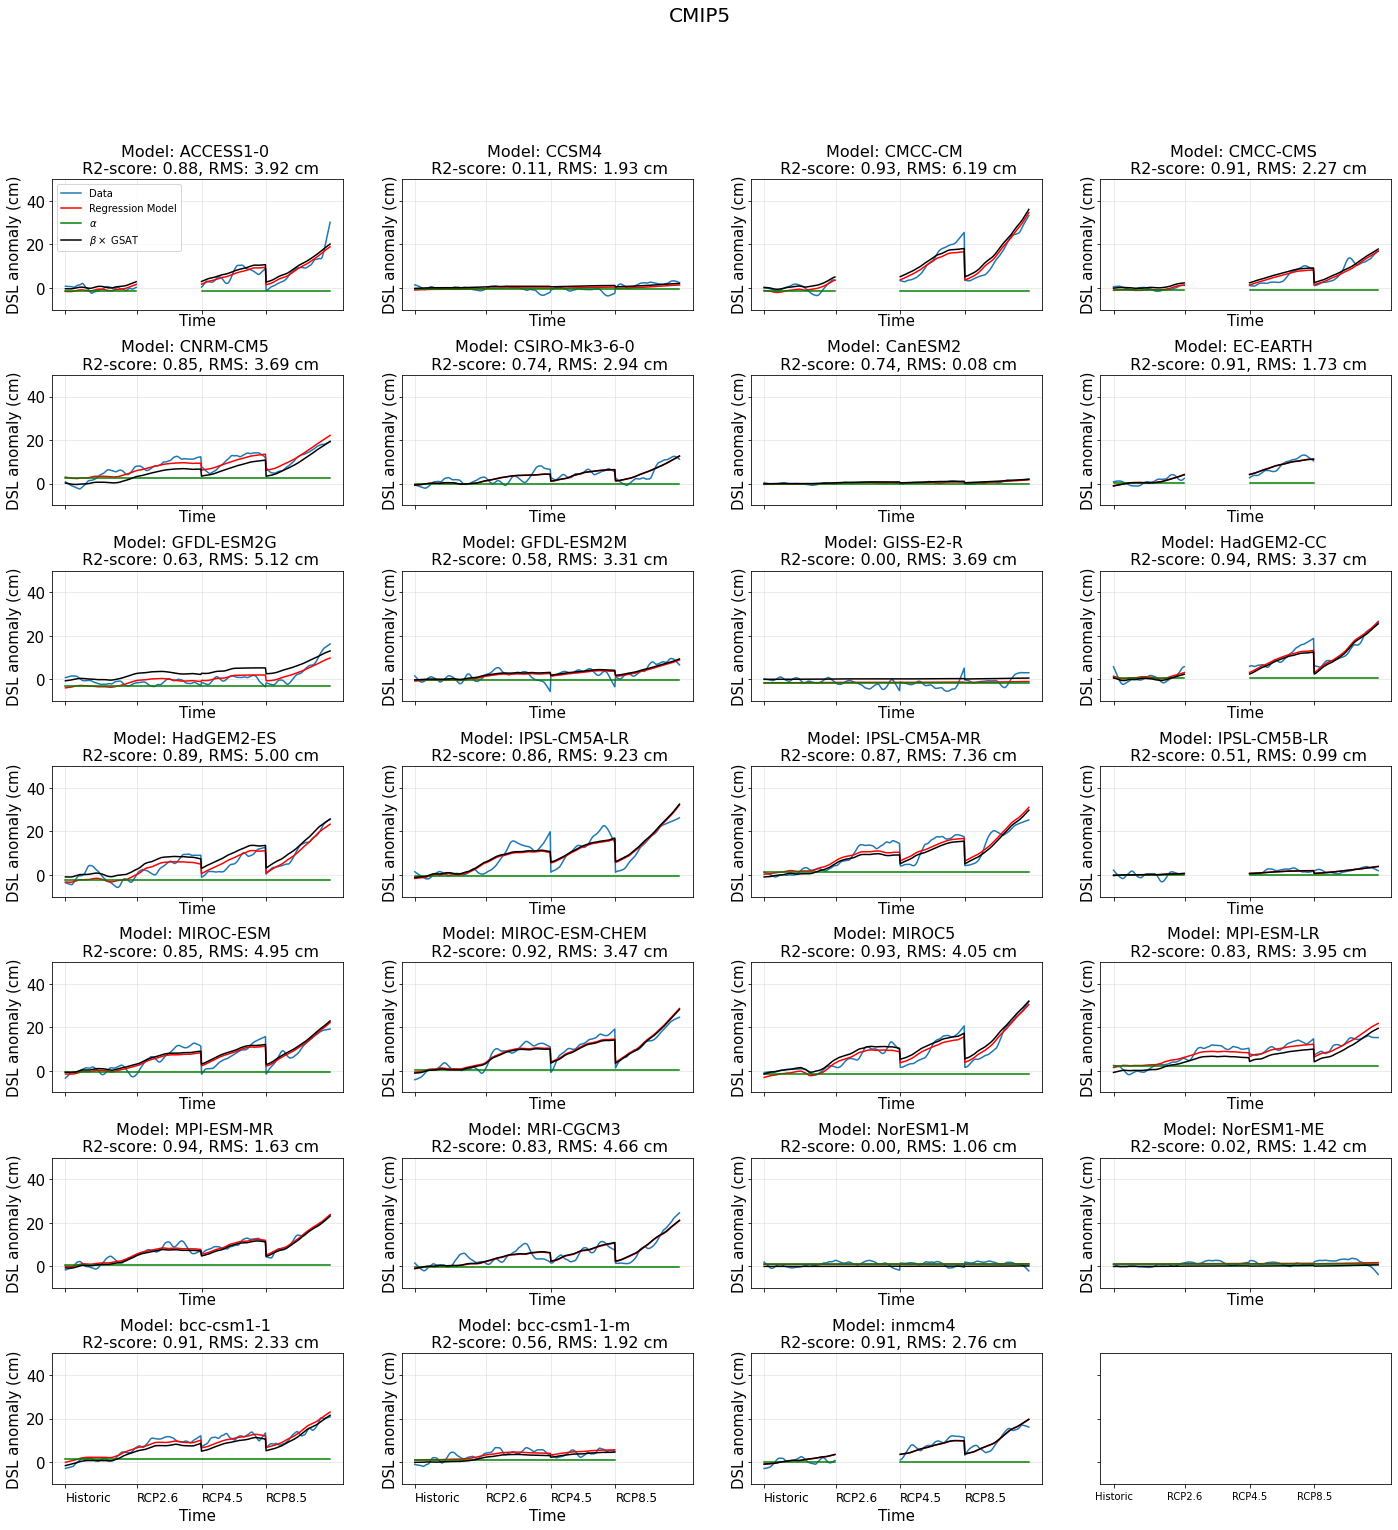

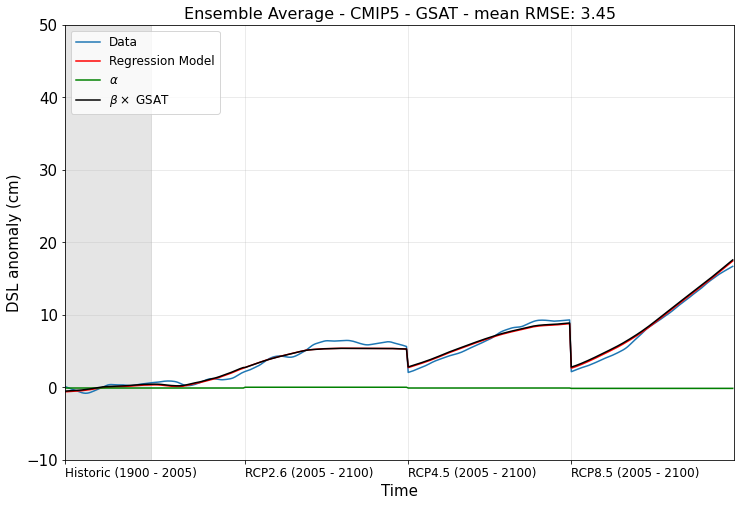

In [67]:
dfs5, mods5, sces5, df_params5 = lin_fit(LF_5,'GSAT')
checks_3(dfs5, df_params5, 'CMIP5', mods5, sces5, 'GSAT')


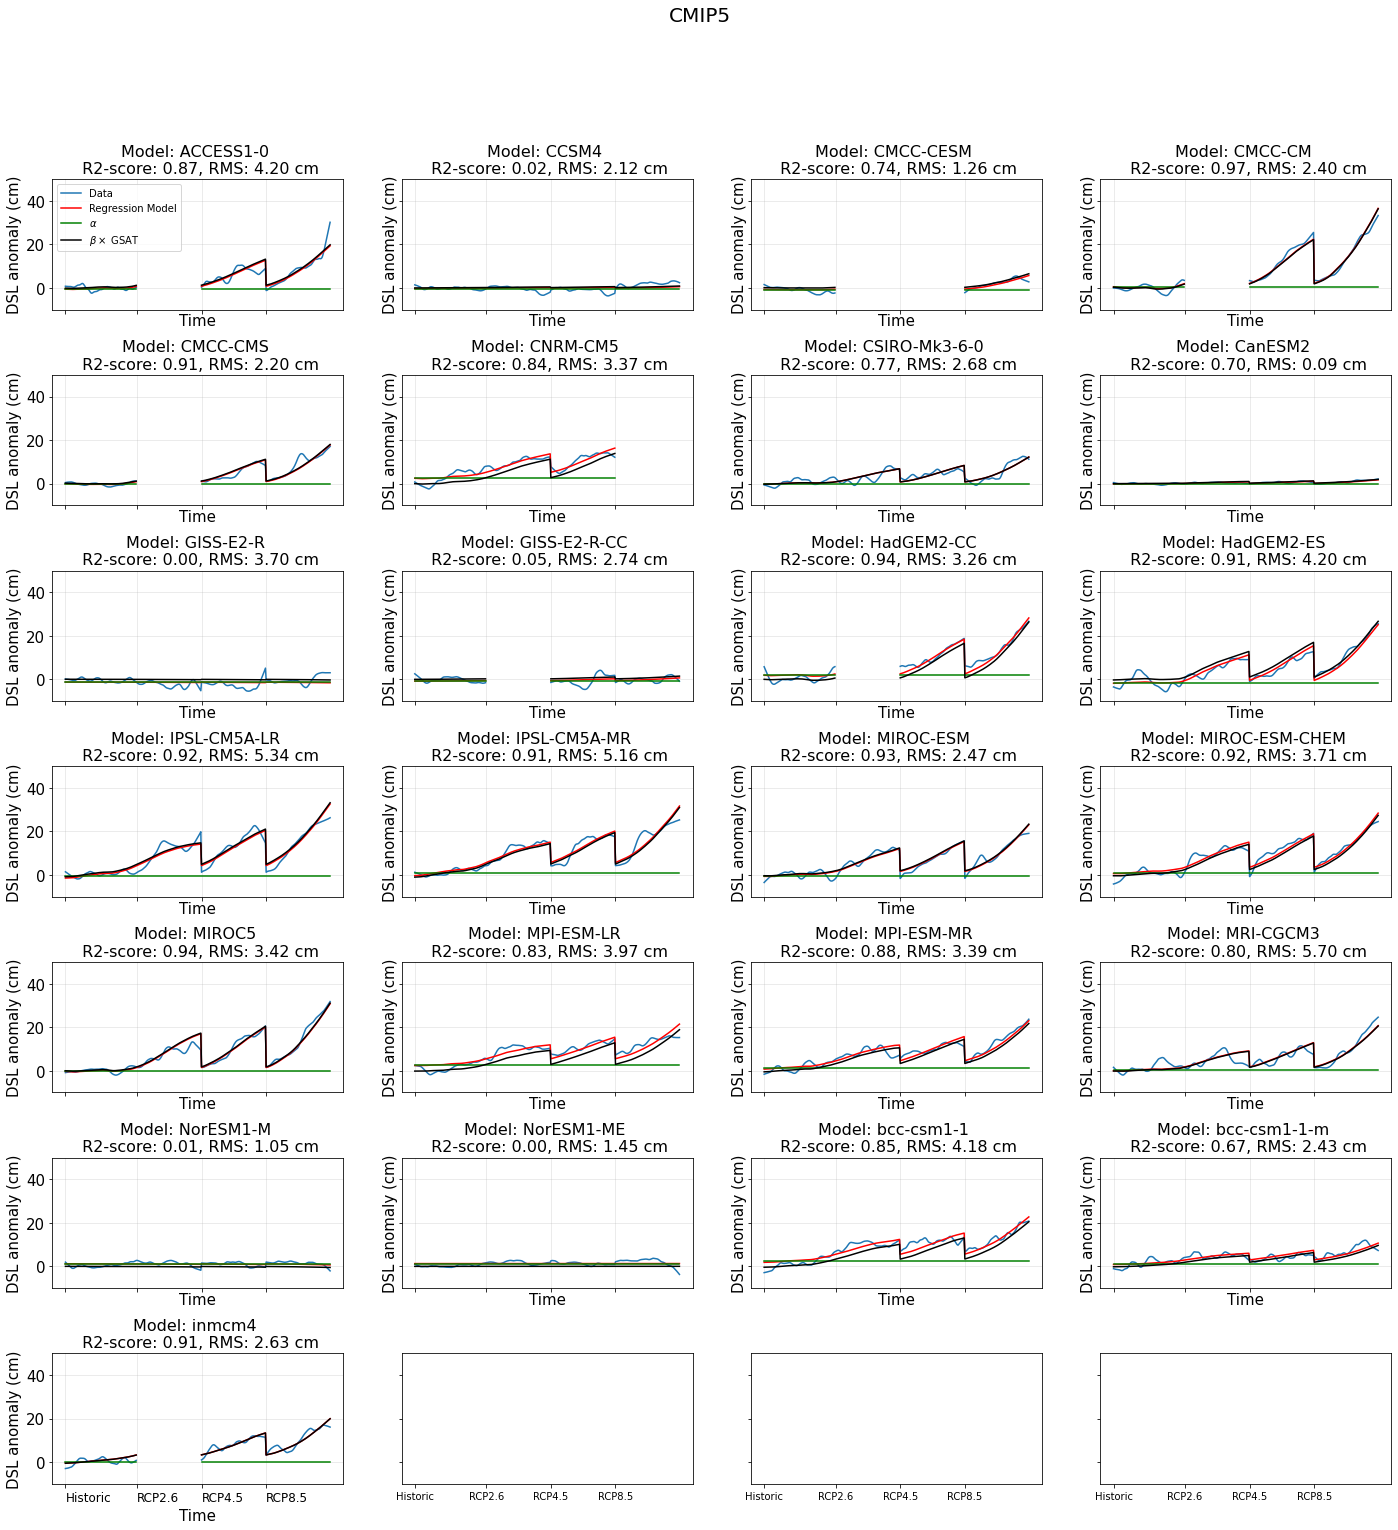

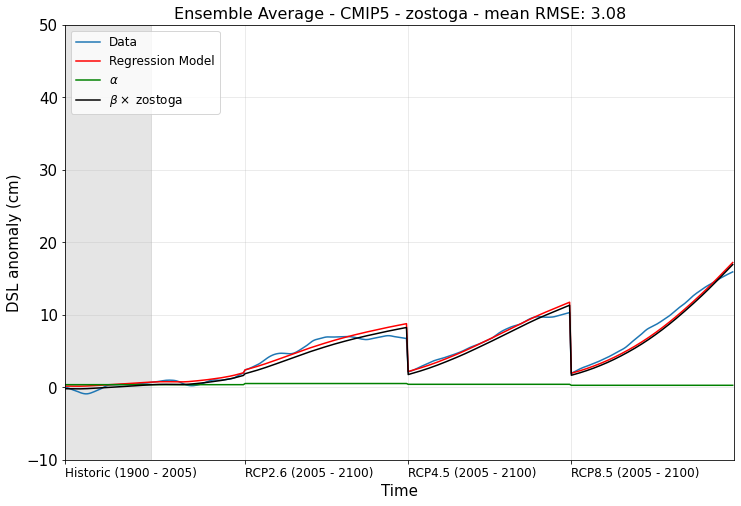

In [68]:
dfs5, mods5, sces5, df_params5 = lin_fit(LF_5,'zostoga')
checks_3(dfs5, df_params5, 'CMIP5', mods5, sces5, 'zostoga')

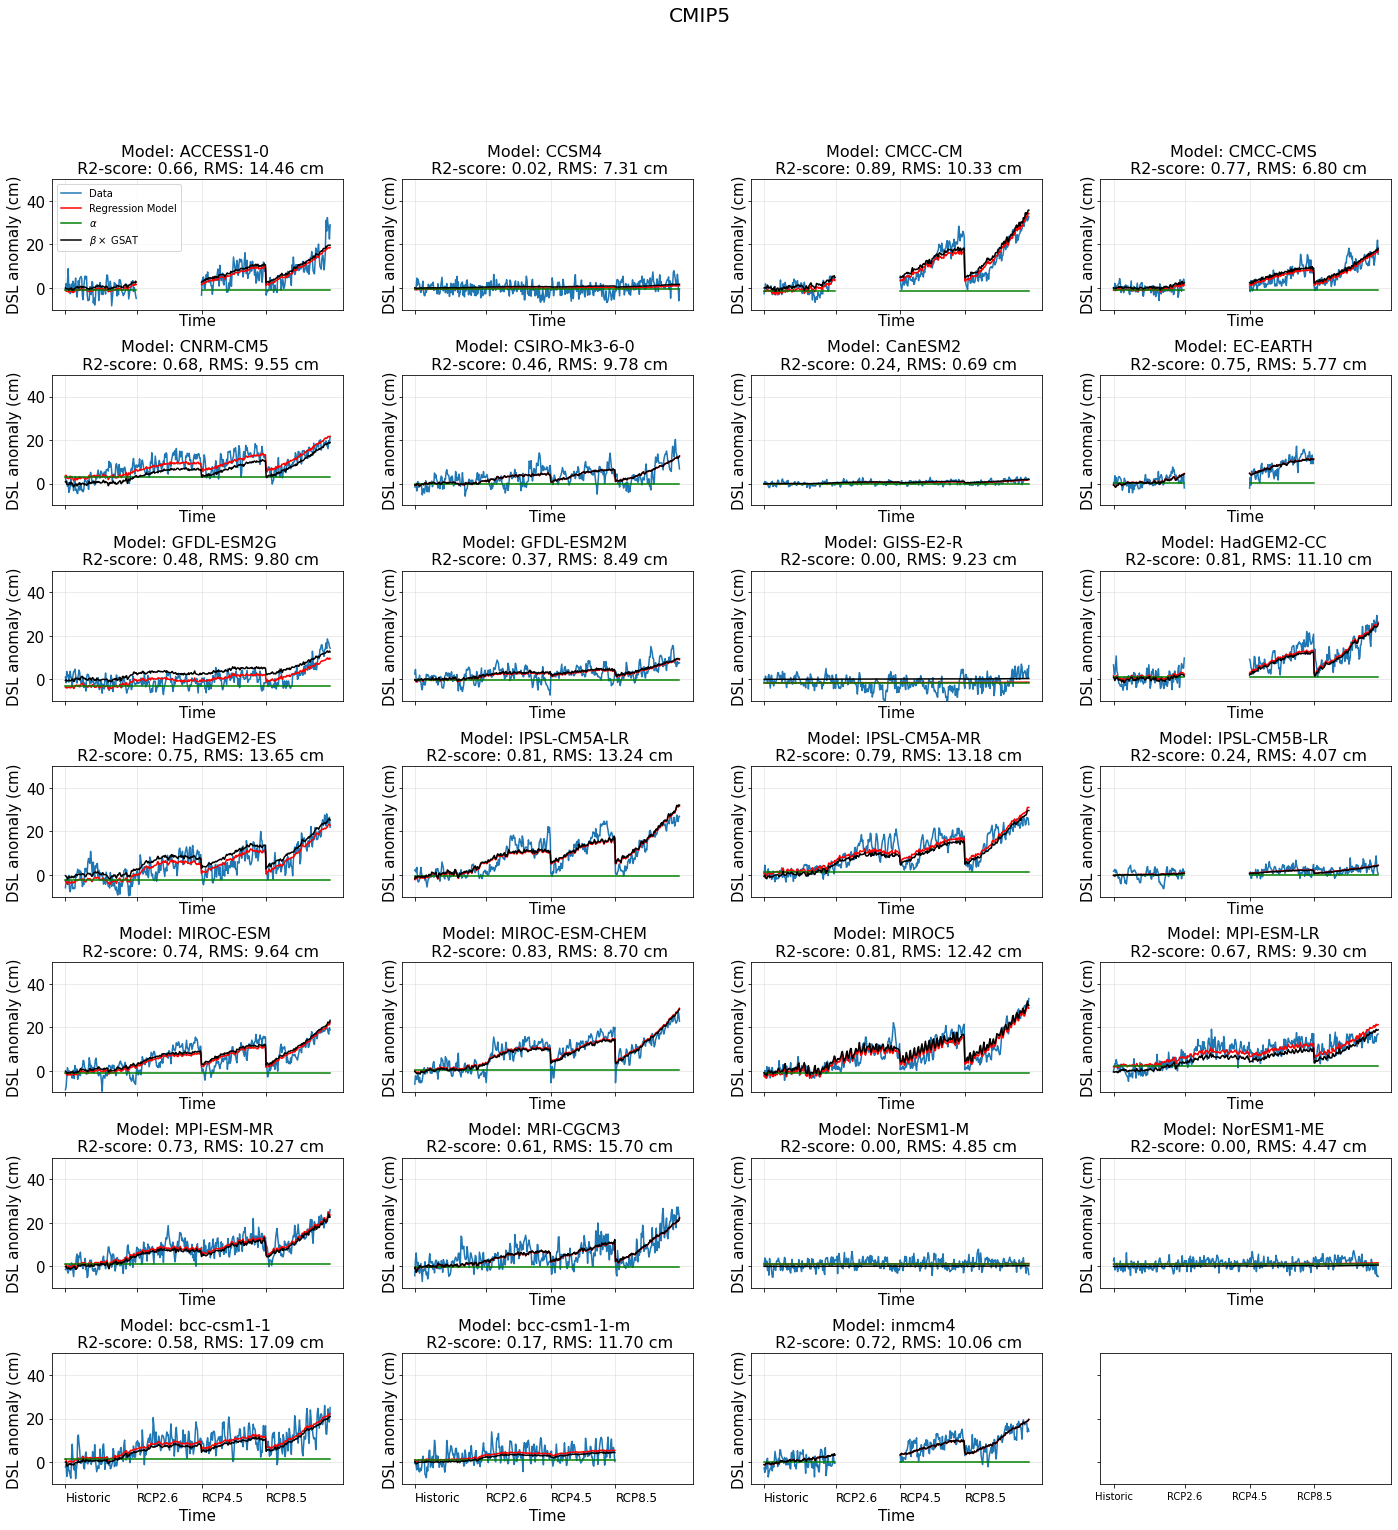

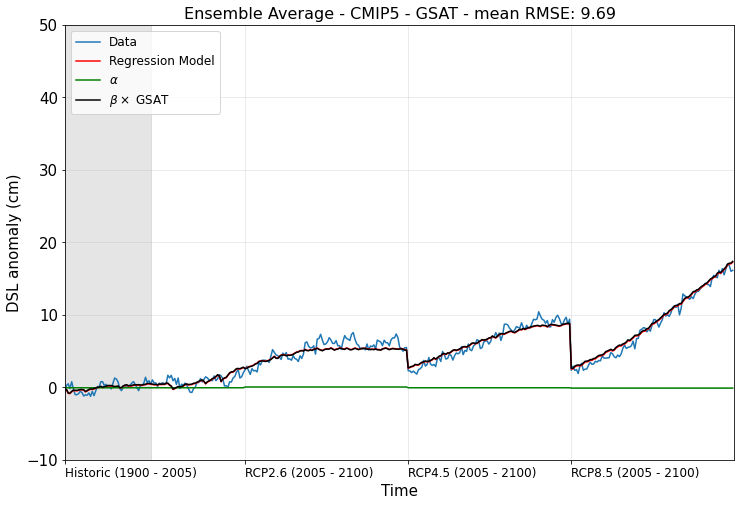

In [77]:
dfs5, mods5, sces5, df_params5 = lin_fit(CMIP5ds,'GSAT')
checks_3(dfs5, df_params5, 'CMIP5', mods5, sces5, 'GSAT')

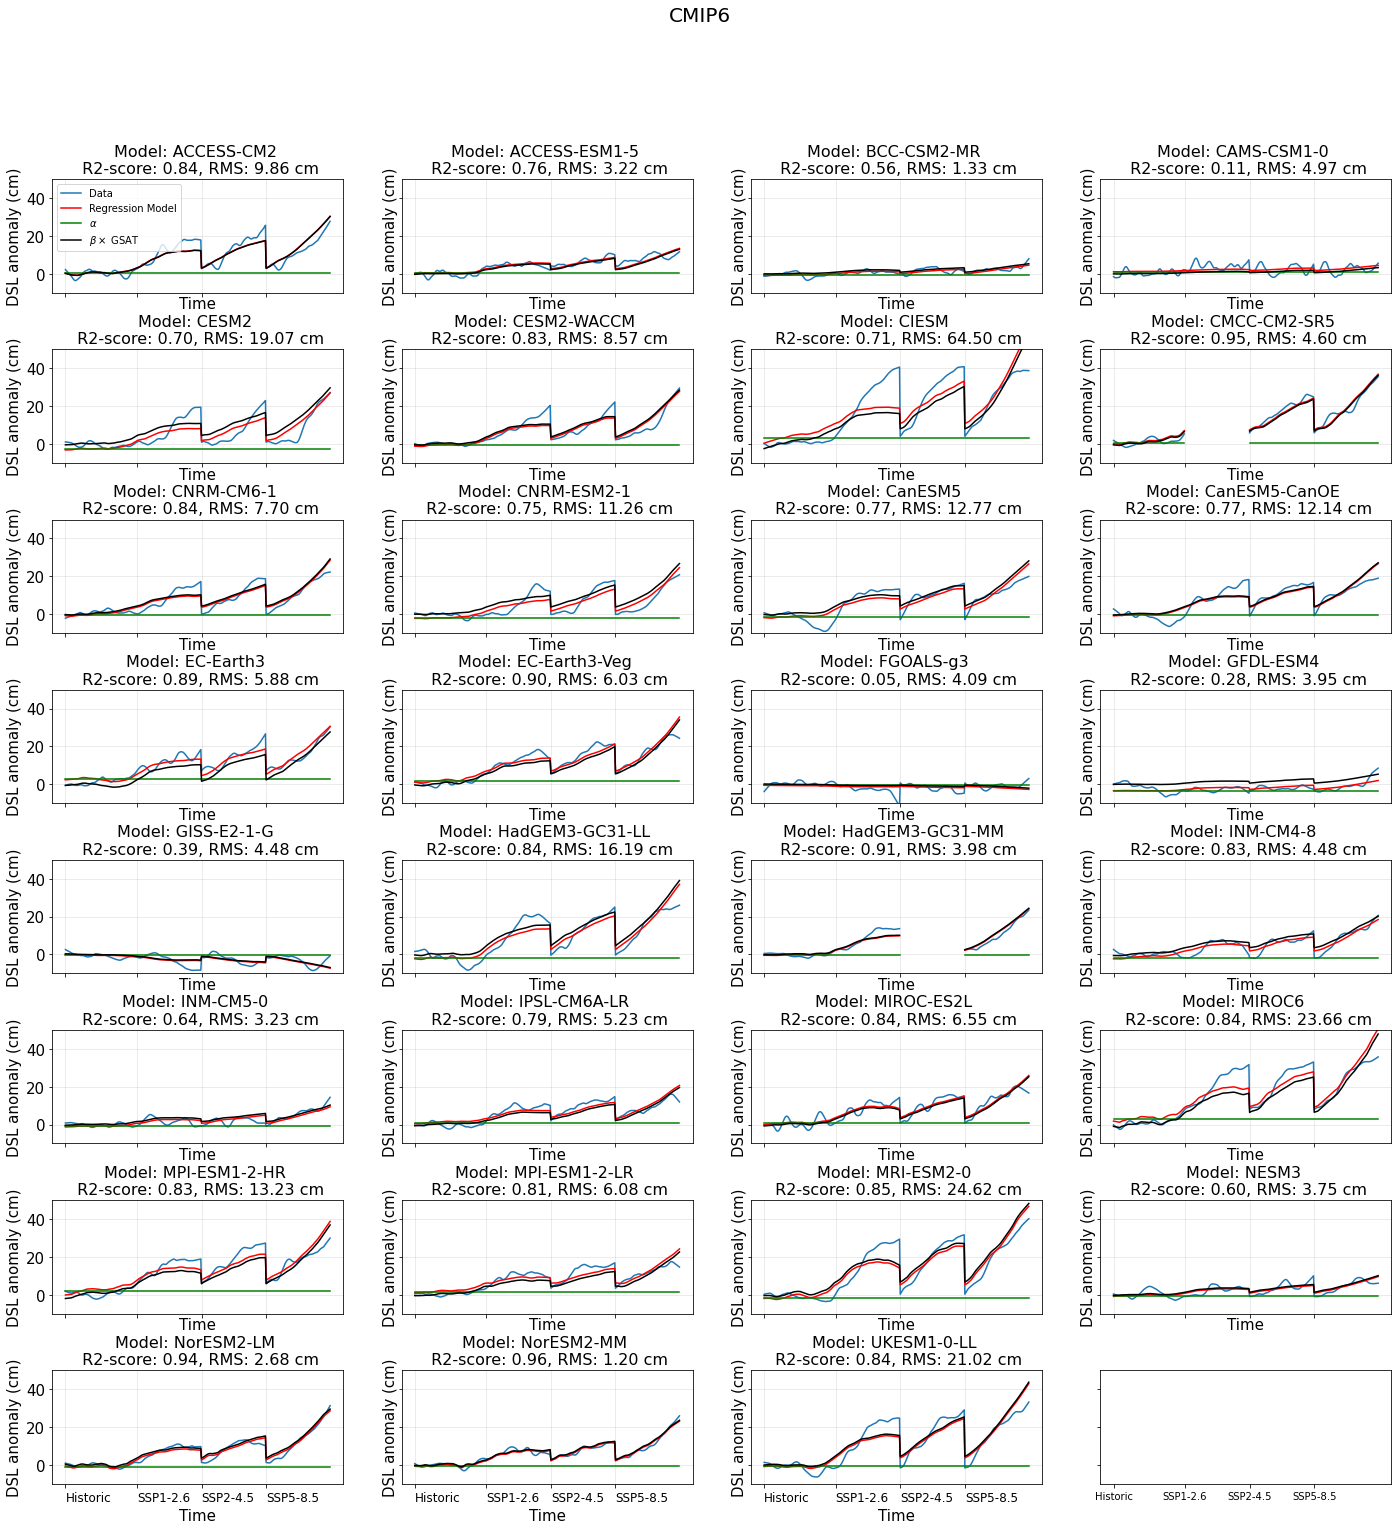

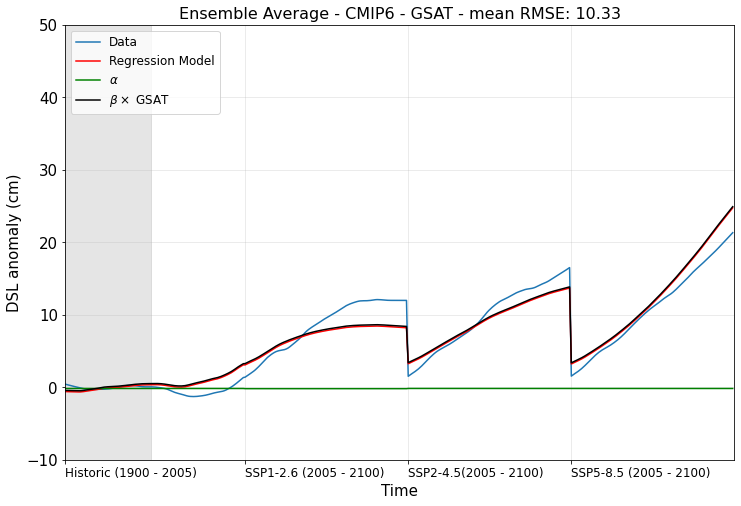

In [69]:
dfs6, mods6, sces6, df_params6 = lin_fit(LF_6,'GSAT')
checks_3(dfs6, df_params6, 'CMIP6', mods6, sces6, 'GSAT')

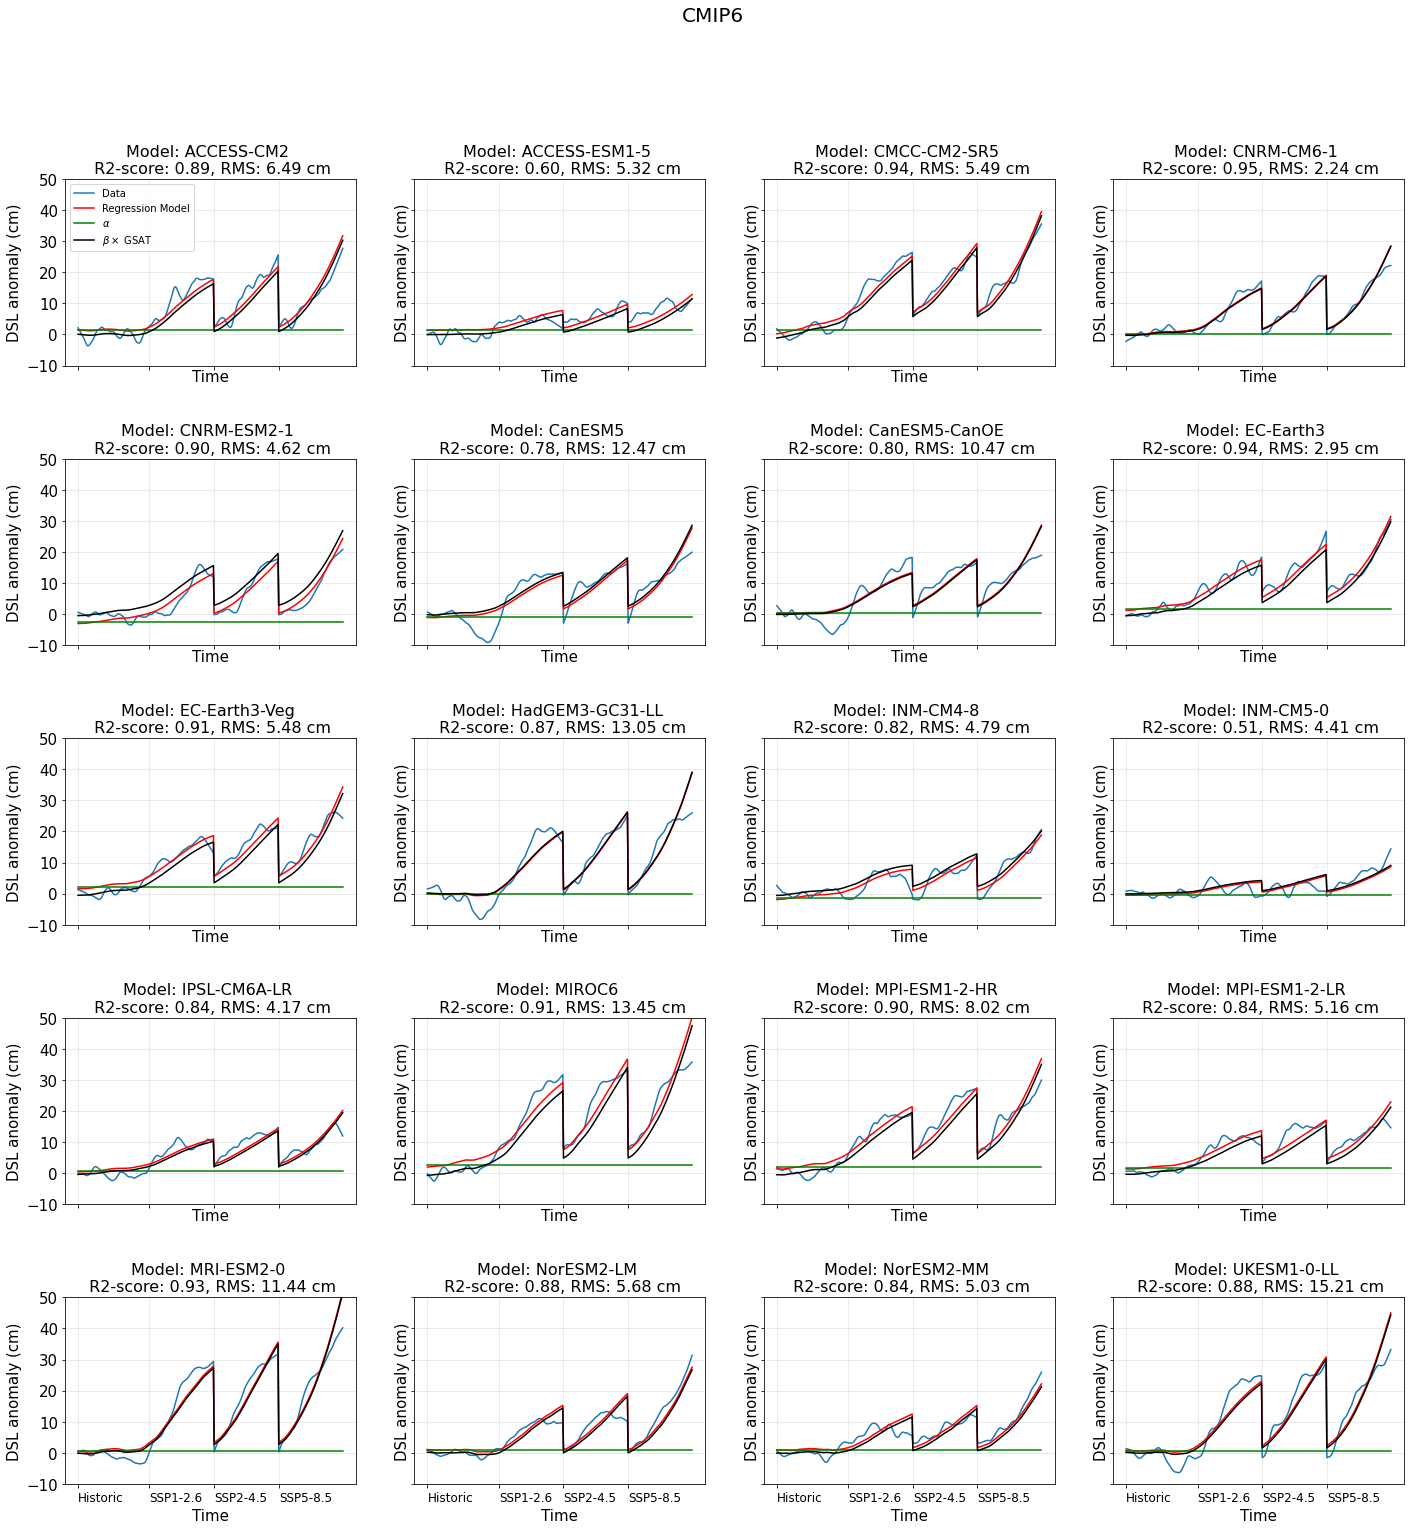

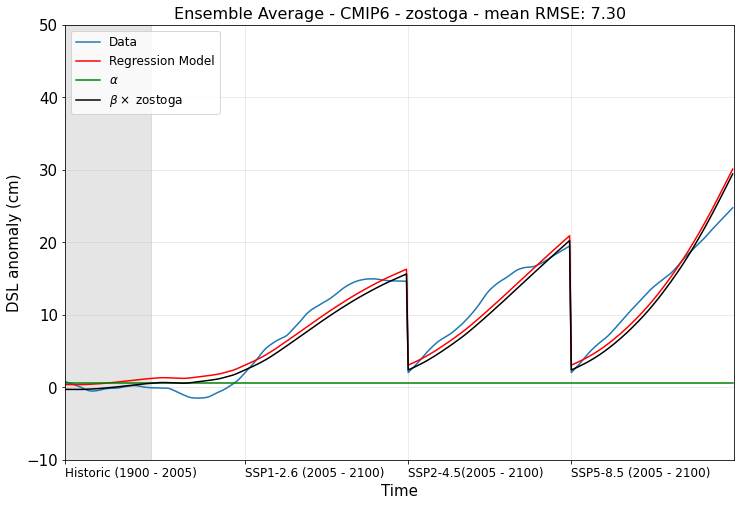

In [70]:
dfs6, mods6, sces6, df_params6 = lin_fit(LF_6,'zostoga')
checks_3(dfs6, df_params6, 'CMIP6', mods6, sces6, 'zostoga')

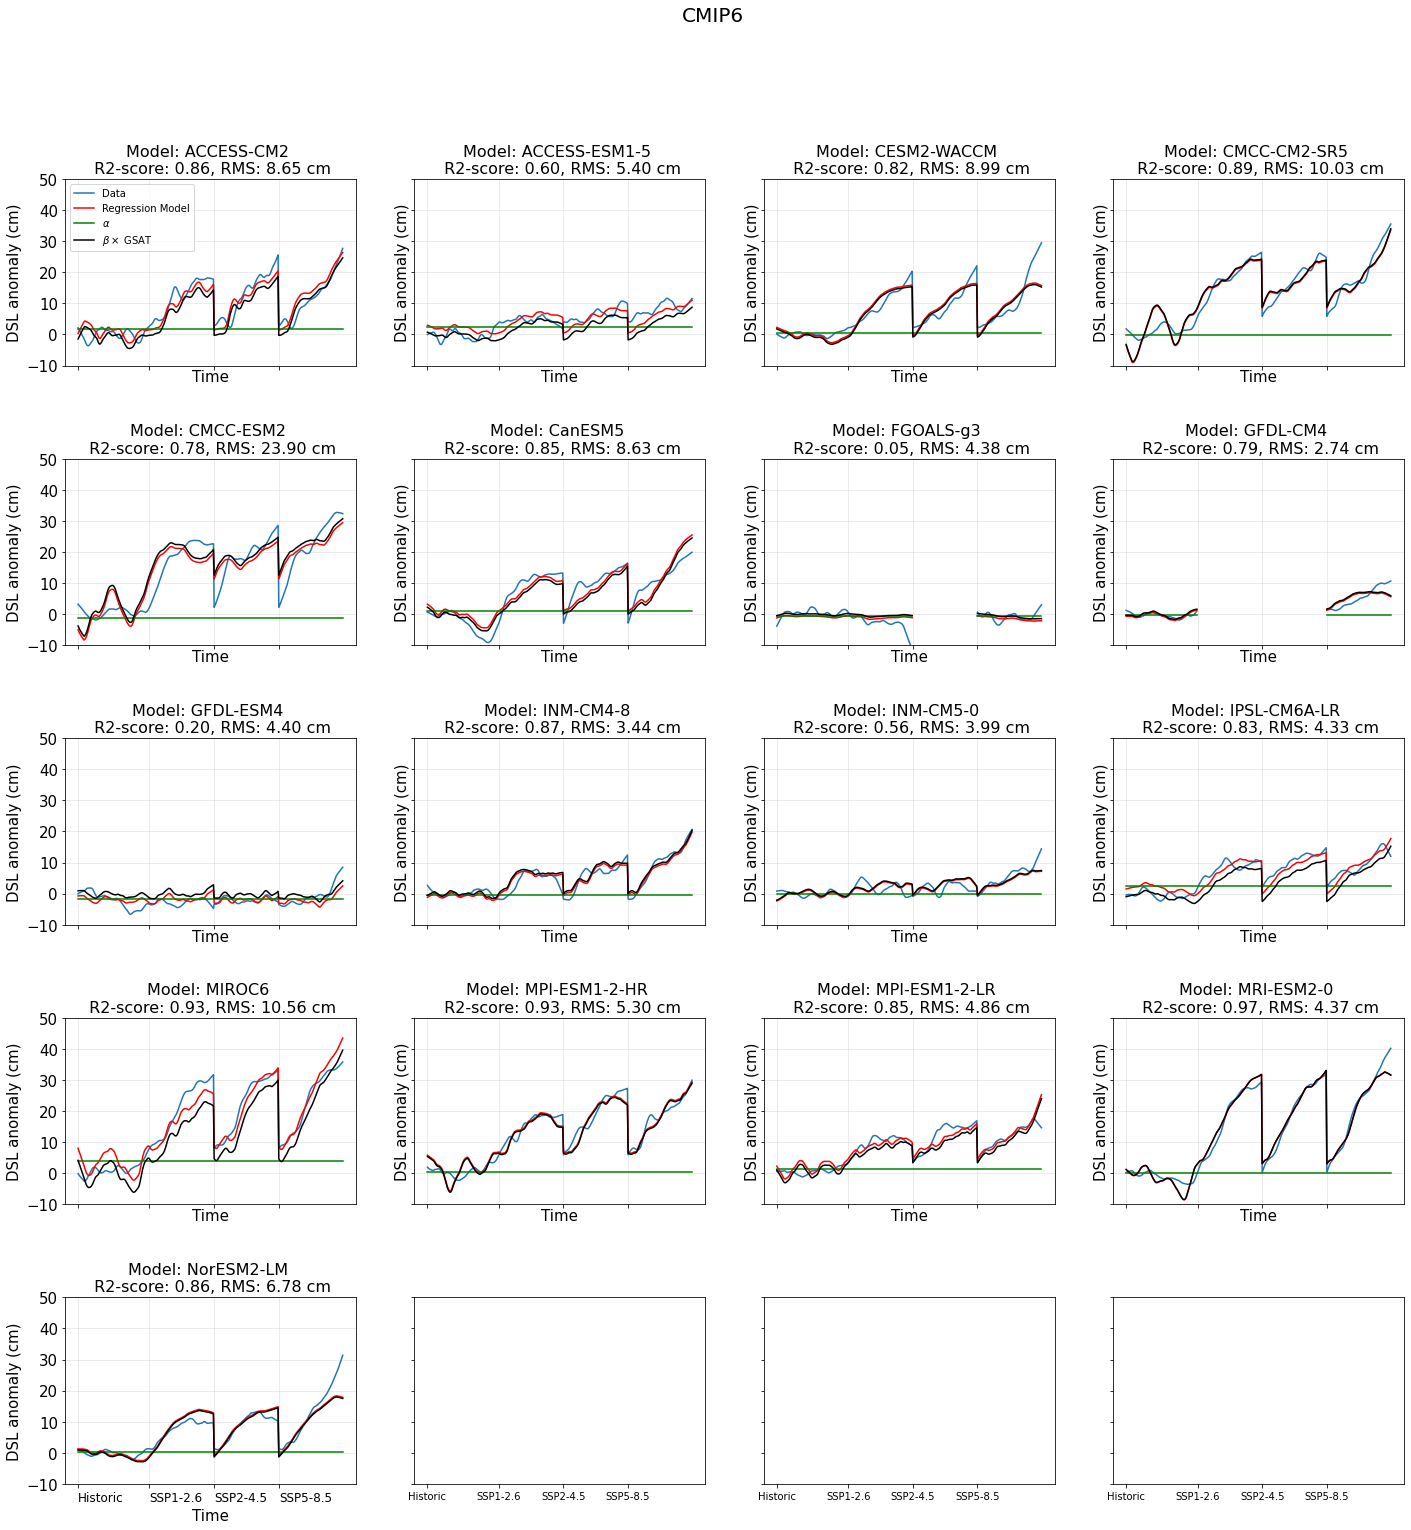

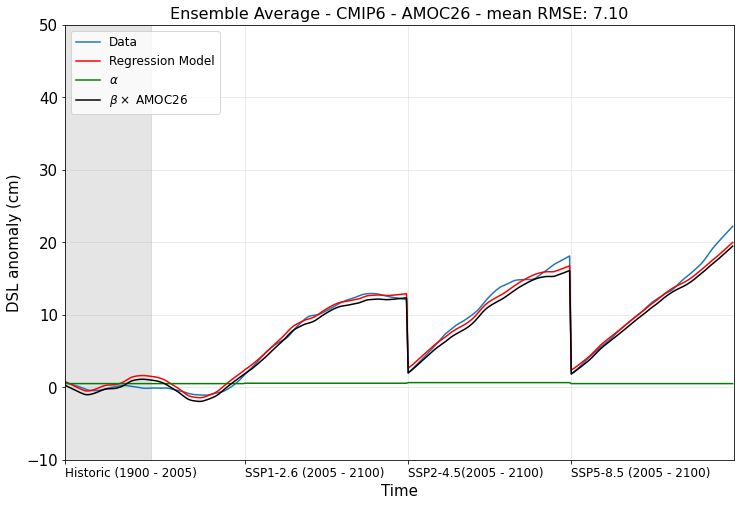

In [71]:
dfs6, mods6, sces6, df_params6 = lin_fit(LF_6,'AMOC26')
checks_3(dfs6, df_params6, 'CMIP6', mods6, sces6, 'AMOC26')

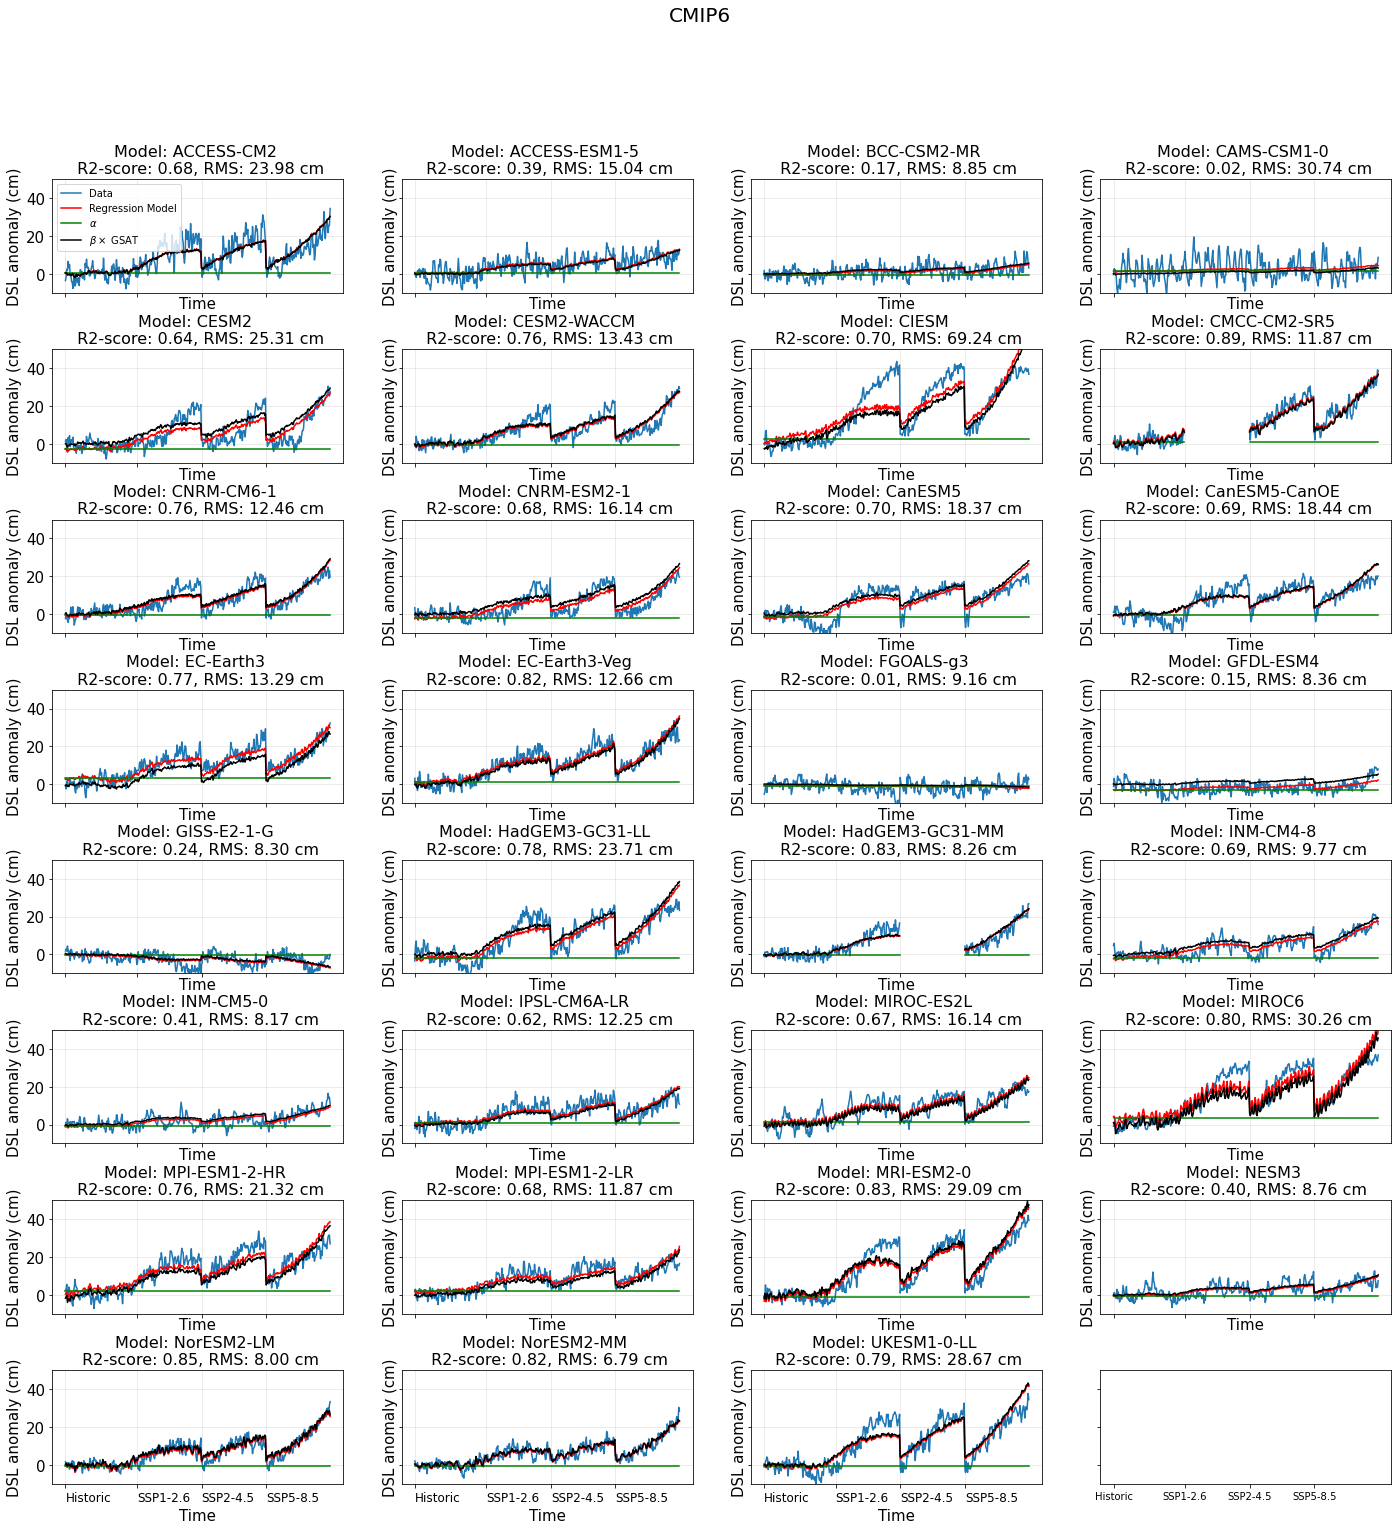

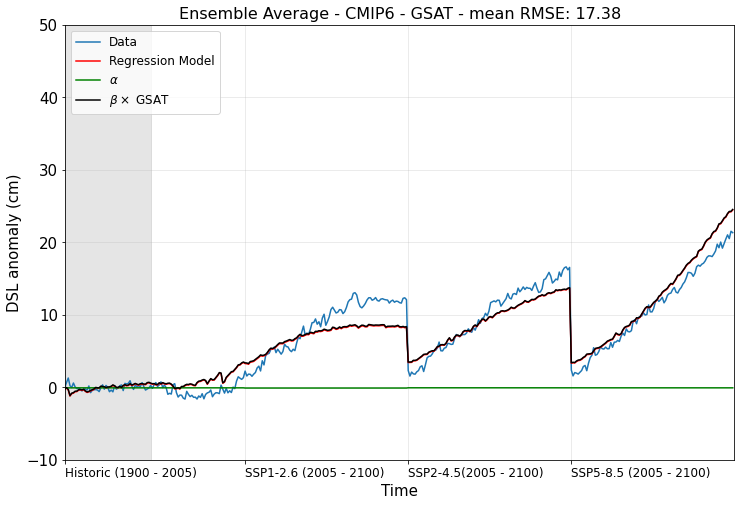

In [74]:
dfs6, mods6, sces6, df_params6 = lin_fit(CMIP6ds,'GSAT')
checks_3(dfs6, df_params6, 'CMIP6', mods6, sces6, 'GSAT')

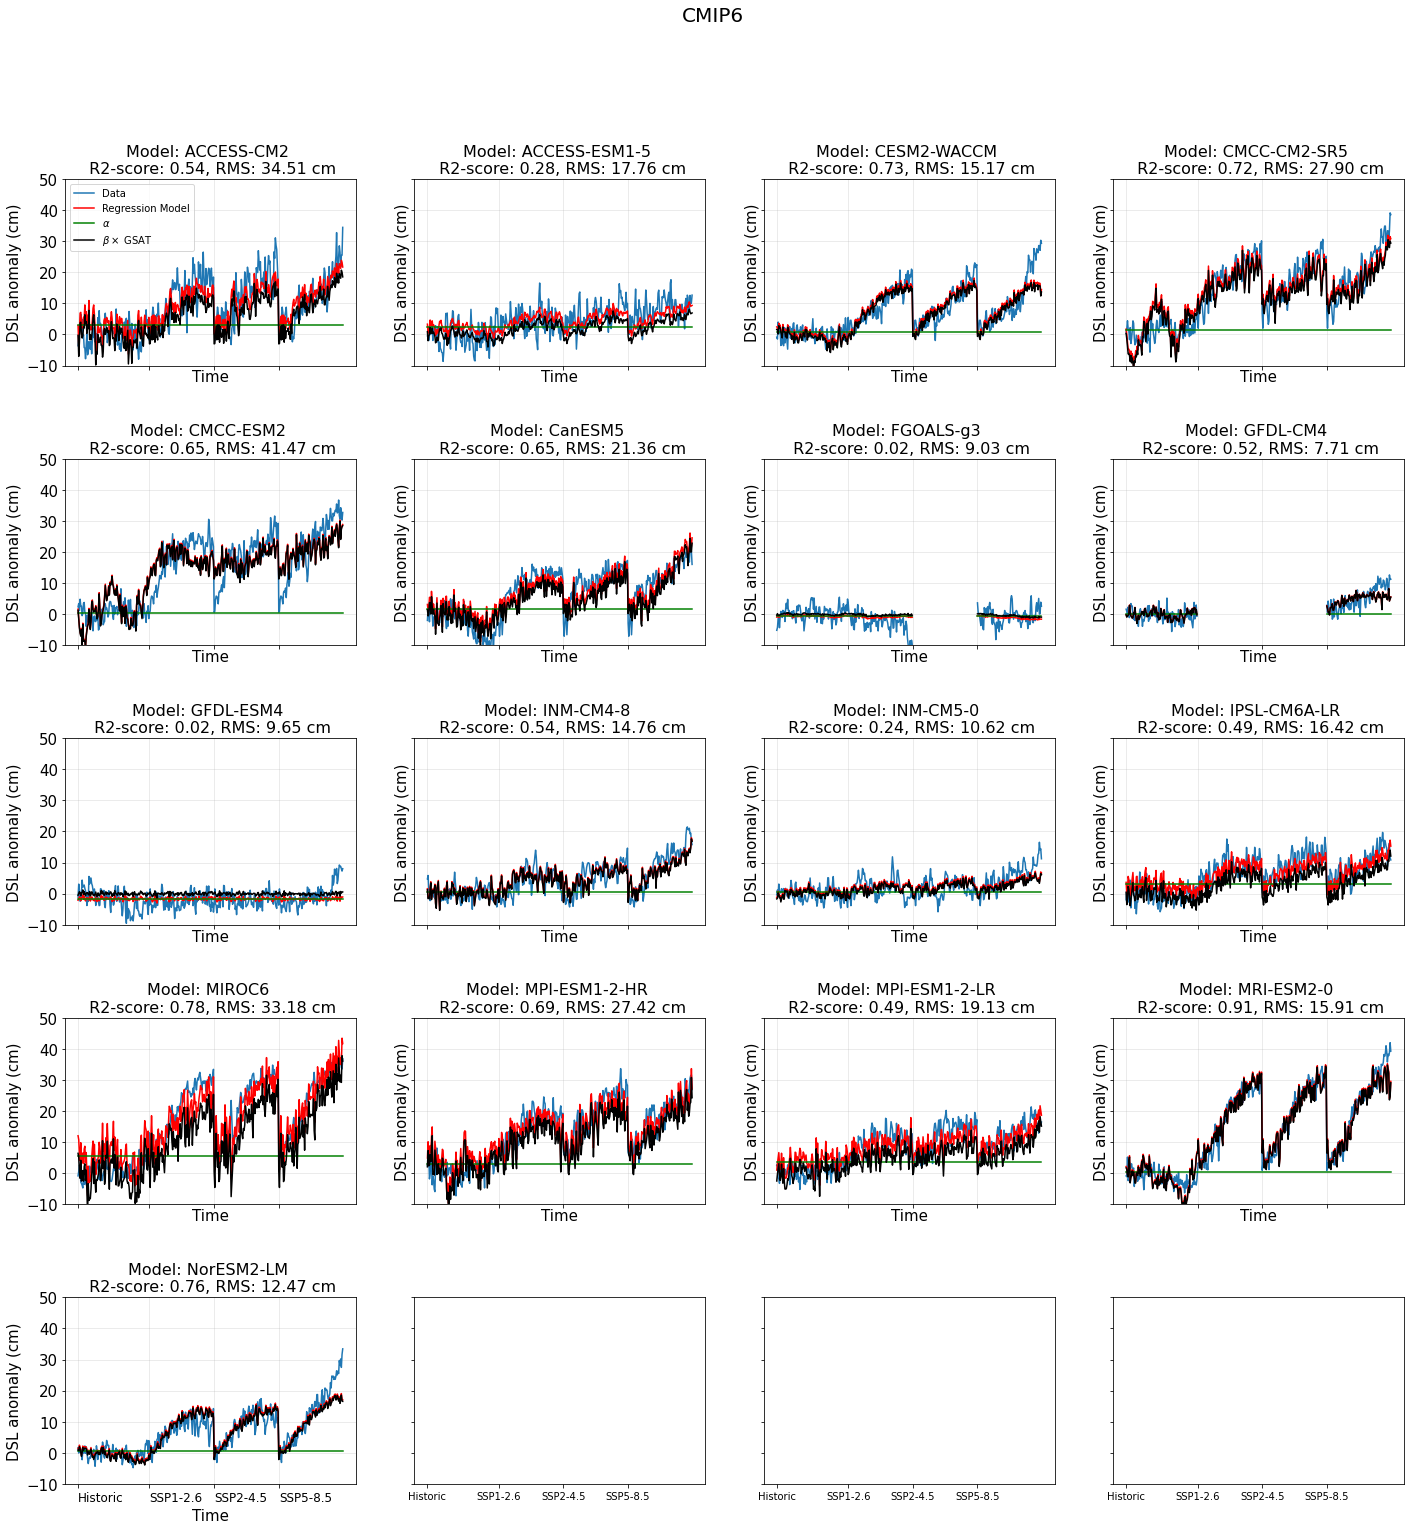

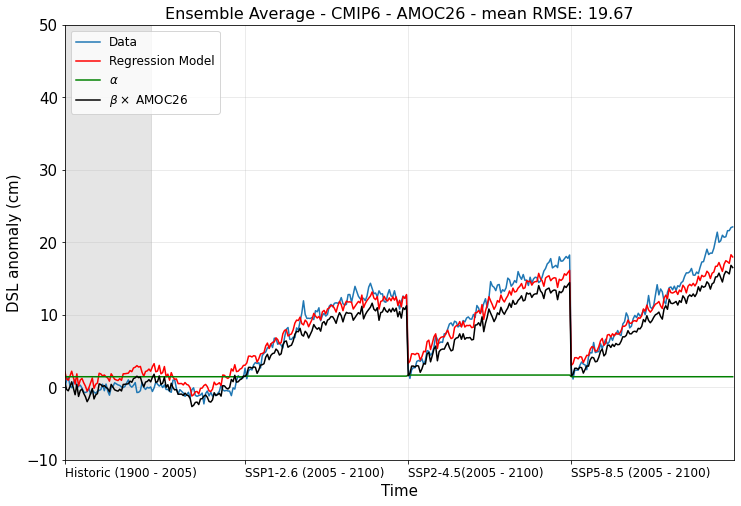

In [75]:
dfs6, mods6, sces6, df_params6 = lin_fit(CMIP6ds,'AMOC26')
checks_3(dfs6, df_params6, 'CMIP6', mods6, sces6, 'AMOC26')

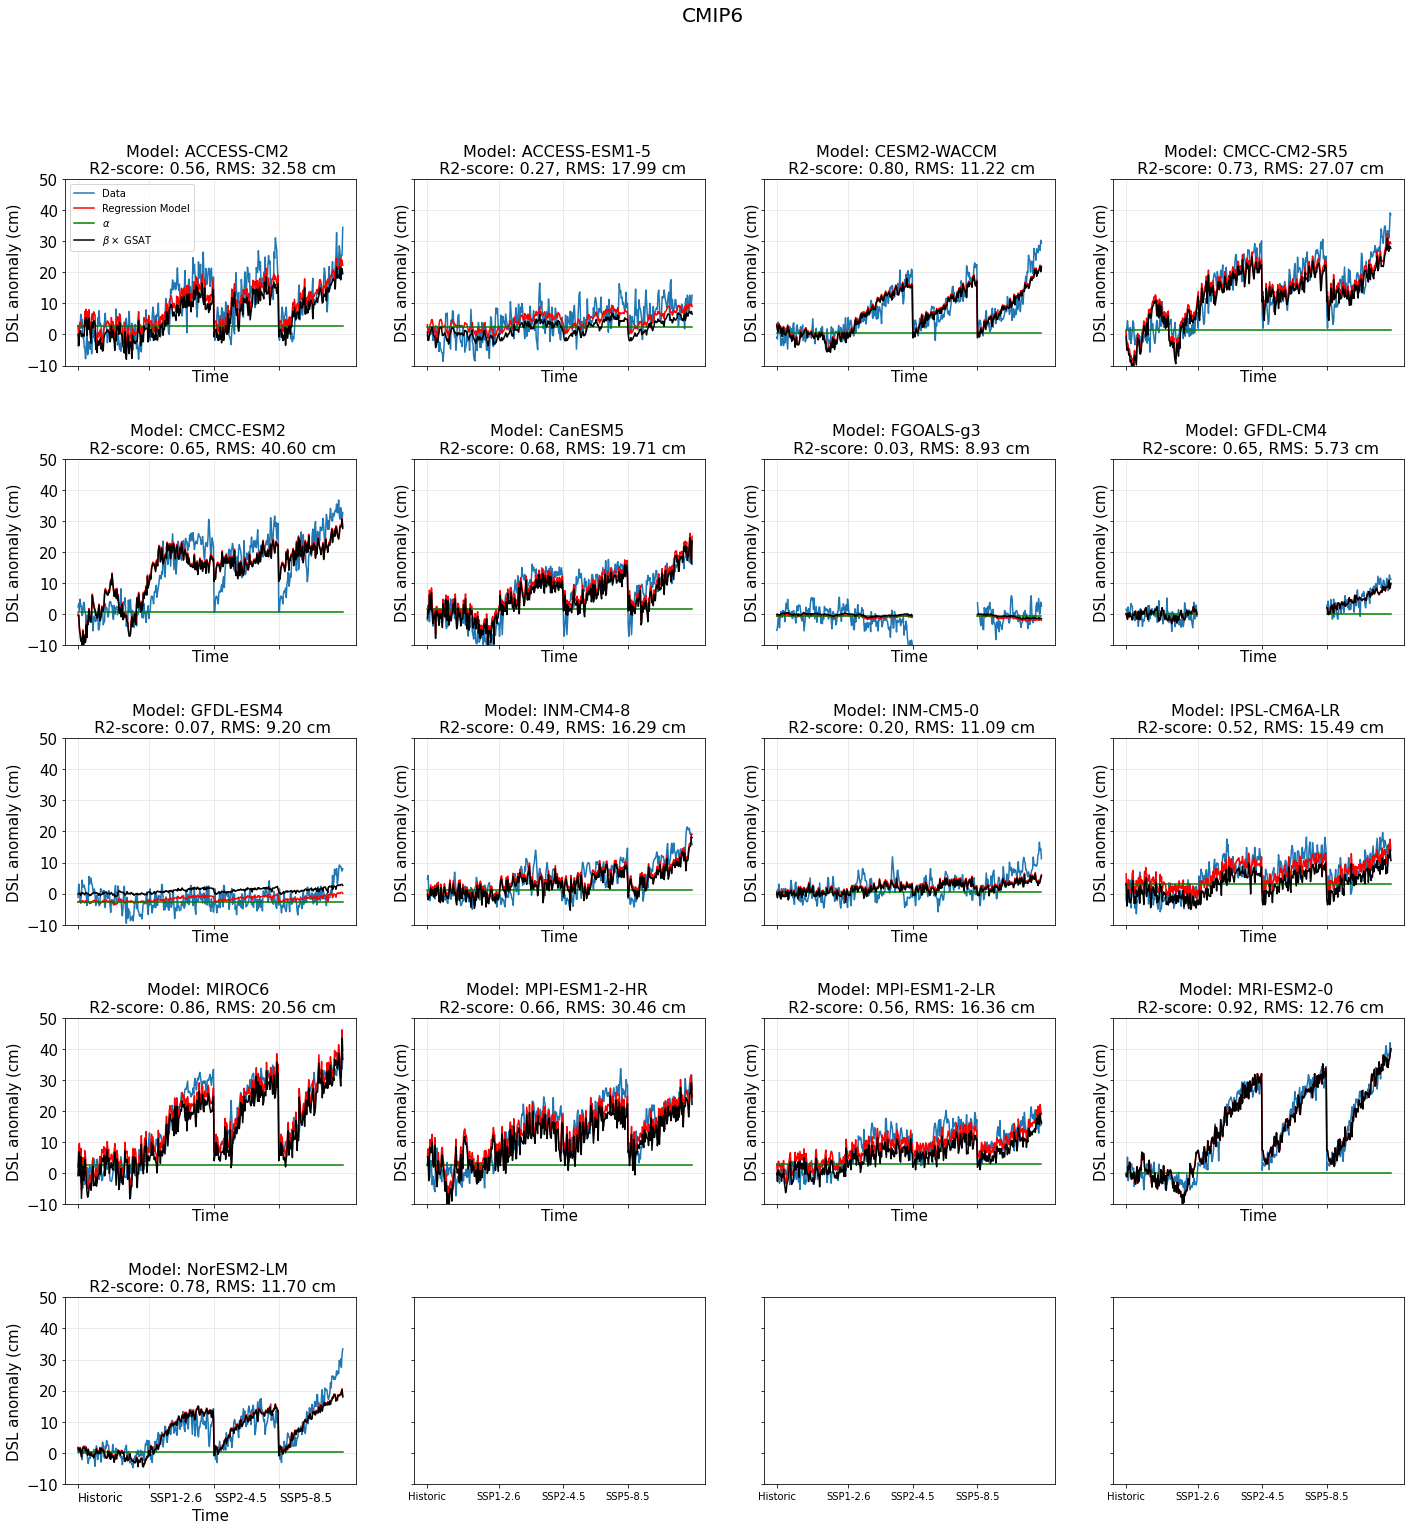

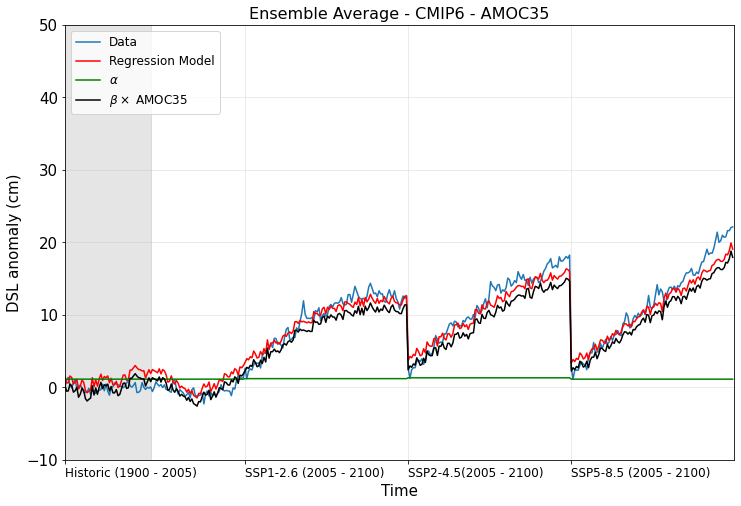

In [135]:
dfs6, mods6, sces6, df_params6 = lin_fit(CMIP6ds,'AMOC35')
checks_3(dfs6, df_params6, 'CMIP6', mods6, sces6,'AMOC35')

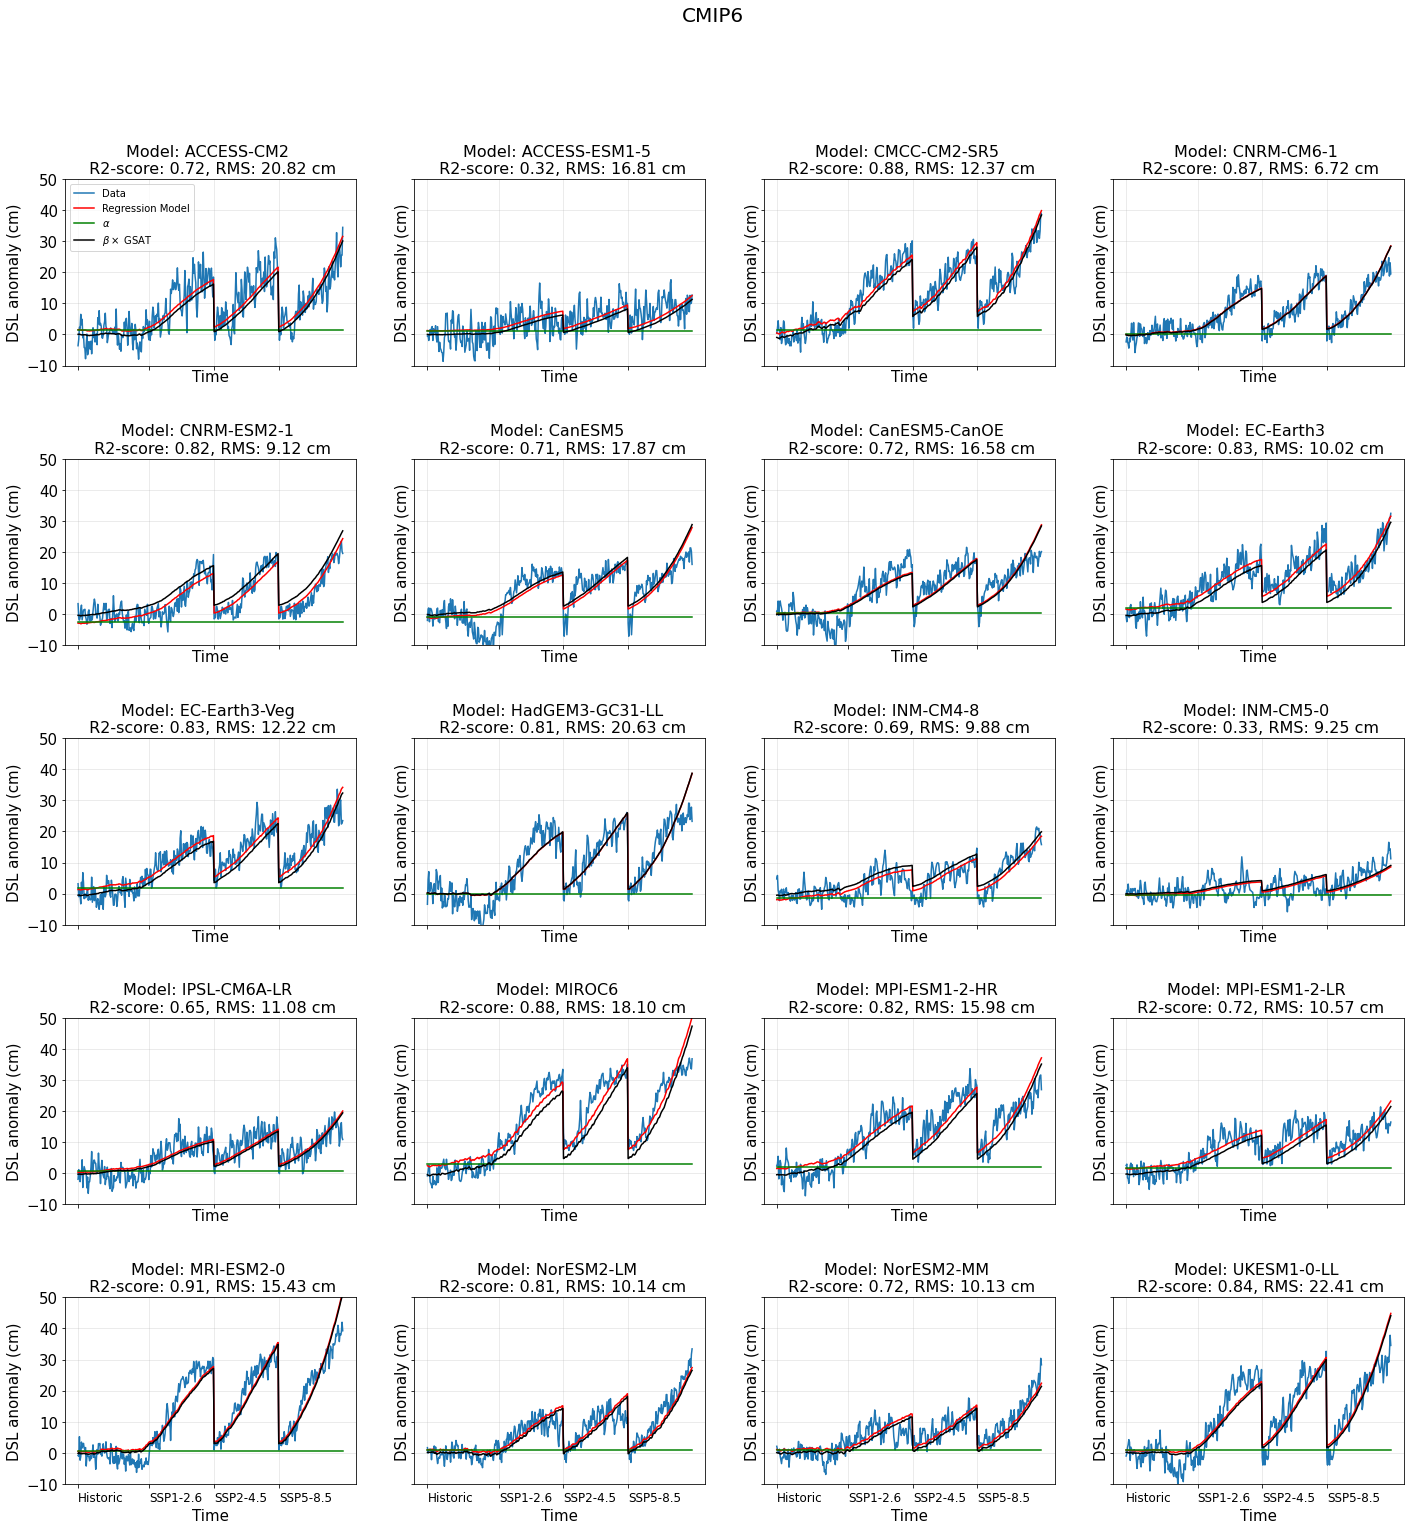

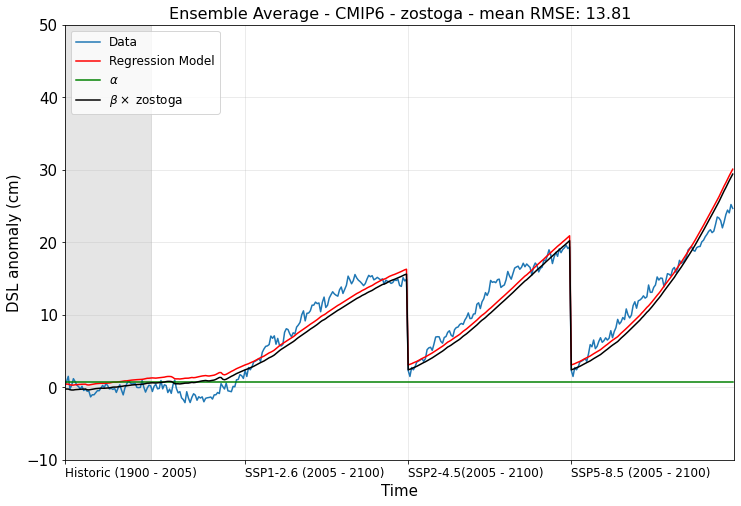

In [76]:
dfs6, mods6, sces6, df_params6 = lin_fit(CMIP6ds,'zostoga')
checks_3(dfs6, df_params6, 'CMIP6', mods6, sces6,'zostoga')

In [9]:
def compute_distr_ensembles(ds, sce, varx):
    '''
    Function that computes percentiles for GSAT and zostoga from model data
    '''
    
    mods = select_models(ds.sel(scenario=sce), varx,'zos','model')[0]
    
    ds = select_models(ds.sel(scenario=sce), varx ,'zos','model')[1]
    #ds = select_models(ds, 'AMOC26','zos','model')[1]

    time = np.arange(1900,2100,1)
    ds = ds.sel(time=slice(1900,2100))

    x1s = ds[varx].values
    
    x1_5, x1_50, x1_95 = [],[],[]
    
    for i in range(len(x1s[0])):
        x1_5.append(np.quantile(x1s[:,i],0.05))
        x1_50.append(np.quantile(x1s[:,i],0.5))
        x1_95.append(np.quantile(x1s[:,i],0.95))

        
    d = {'Date': time, 'x1_5th': x1_5, 'x1_50th': x1_50, 'x1_95th': x1_95}
    df = pd.DataFrame(data=d)
    df = df.set_index('Date')
    
    return df


In [245]:
func_cdf = stats.skewnorm # stats.gamma, stats.weibull_min , stats.skewnorm, stats.genextreme, stats.lognorm
pc = np.array([5,50,95])*0.01

def range_to_dist(df, var, n, st_yr, end_yr):
    
    def func(x, a, scale):
        return func_cdf.cdf(x, a, iloc, scale)

    mus = []
    stds = []
    distrs = []

    for i in np.arange(st_yr, end_yr):
        col = i
        
        if var == 'x1':
            data_sel = df.loc[col][0:3].values + np.array([50])
        elif var == 'x2':
            data_sel = df.loc[col][3:6].values + np.array([50])
        #print(col)  
        #print(data_sel)
        
        iloc = data_sel[0]-0.05
        popt, pcov = curve_fit(func, data_sel, pc)
        err = np.square(func(data_sel.astype(float), popt[0], popt[1]) - pc).mean()
    
    
        # Calculate mu and sigma for probability function
        mu = func_cdf.mean(popt[0], iloc, popt[1])
        sigma = func_cdf.std(popt[0], iloc, popt[1])
    
        mus.append(mu) 
        stds.append(sigma)
    
        mu_new = np.log(mu**2/np.sqrt(mu**2+sigma**2))
        sigma_new = np.sqrt(np.log(1+(sigma**2/mu**2)))
    
        # Sample n values from distribution and store in array
        distr = np.random.lognormal(mu_new, sigma_new, n)
        distr = np.sort(distr) - np.array([50])
        
        # Save distribution to array
        distrs.append(distr)
                  
    return distrs


def range_to_dist_obs(df, var, n, st_yr, end_yr):
    '''
    INPUT:
        - df: dataframe as above
        - var: either 'GSAT' or 'zostoga'
        - pc: percentiles: ea [5, 50, 95]
        - n: number of samples you want to generate
    OUTPUT:
        - random distribution with n values
    '''
    def func(x, a, scale):
        return func_cdf.cdf(x, a, iloc, scale)

    distrs = []
    func_cdf = stats.lognorm
        
    for i in range(st_yr,end_yr+1):
        yr = i
        if var == 'obs_GS':
            data_sel = np.sort(df.loc[yr][0:3]) + np.array([50])
            pc = np.array([2.5,50,97.5])*0.01
            
        elif var == 'obs_zt':
            data_sel = np.sort(df.loc[yr][3:6]) + np.array([50])
            pc = np.array([5,50,95])*0.01
        
        
        iloc = data_sel[0]-0.05
        popt, pcov = curve_fit(func, data_sel, pc)
        err = np.square(func(data_sel.astype(float), popt[0], popt[1]) - pc).mean()
    
        # Calculate mean and std for probability function
        mean = func_cdf.mean(popt[0], iloc, popt[1])
        std = func_cdf.std(popt[0], iloc, popt[1])
        
        # Translate to mu and sigma
        mu = np.log(mean**2/np.sqrt(mean**2+std**2))
        sigma = np.sqrt(np.log(1+(std**2/mean**2)))
        
        # Sample n values from distribution and store in array
        distr = np.random.lognormal(mu, sigma, n)
        distr = np.sort(distr) - np.array([50])
        
        # Save distribution to array
        distrs.append(distr)
    
    return distrs


func_cdf = stats.lognorm # stats.gamma, stats.weibull_min , stats.skewnorm, stats.genextreme, stats.lognorm
pc = np.array([5,50,95])*0.01
#iloc = -0.5

def func(x, a, scale):
    return func_cdf.cdf(x, a, iloc, scale)

def range_to_dist(df, var, n, st_yr, end_yr):
    '''
    INPUT:
        - df: dataframe as above
        - var: either 'GSAT' or 'zostoga'
        - pc: percentiles: ea [5, 50, 95]
        - n: number of samples you want to generate
    OUTPUT:
        - random distribution with n values
    '''
    distrs = []
    func_cdf = stats.lognorm

    for i in range(st_yr,end_yr+1):
        yr = i
        
        if var == 'GSAT':
            data_sel = df.loc[yr][0:3]
            print(data_sel)
            pc = np.array([5,50,95])*0.01
            
        elif var == 'zostoga':
            data_sel = df.loc[yr][3:6]
            pc = np.array([5,50,95])*0.01

        iloc = data_sel[0]-0.05
        popt, pcov = curve_fit(func, data_sel, pc)
        err = np.square(func(data_sel.astype(float), popt[0], popt[1]) - pc).mean()
    
        # Calculate mean and std for probability function
        mean = func_cdf.mean(popt[0], iloc, popt[1])
        std = func_cdf.std(popt[0], iloc, popt[1])
        
        # Translate to mu and sigma
        mu = np.log(mean**2/np.sqrt(mean**2+std**2))
        sigma = np.sqrt(np.log(1+(std**2/mean**2)))
        
        # Sample n values from distribution and store in array
        distr = np.random.lognormal(mu, sigma, n)
        distr = np.sort(distr)
        
        # Save distribution to array
        distrs.append(distr)
        
    return distrs

def range_to_dist_obs(df, var, n, st_yr, end_yr):
    '''
    INPUT:
        - df: dataframe as above
        - var: either 'GSAT' or 'zostoga'
        - pc: percentiles: ea [5, 50, 95]
        - n: number of samples you want to generate
    OUTPUT:
        - random distribution with n values
    '''
    distrs = []
    func_cdf = stats.lognorm
        
    for i in range(st_yr,end_yr+1):
        yr = i
        
        if var == 'obs_GS':
            data_sel = df.loc[yr][0:3]
            pc = np.array([2.5,50,97.5])*0.01
            
        elif var == 'obs_zt':
            data_sel = df.loc[yr][3:6]
            pc = np.array([5,50,95])*0.01
        
        #print(data_sel)
        iloc = -10
        popt, pcov = curve_fit(func, data_sel, pc)
        err = np.square(func(data_sel.astype(float), popt[0], popt[1]) - pc).mean()
    
        # Calculate mean and std for probability function
        mean = func_cdf.mean(popt[0], iloc, popt[1])
        std = func_cdf.std(popt[0], iloc, popt[1])
        
        # Translate to mu and sigma
        mu = np.log(mean**2/np.sqrt(mean**2+std**2))
        sigma = np.sqrt(np.log(1+(std**2/mean**2)))
        
        # Sample n values from distribution and store in array
        distr = np.random.lognormal(mu, sigma, n)
        distr = np.sort(distr)
        
        # Save distribution to array
        distrs.append(distr)
    
    return distrs

In [246]:
n = 1000

### Distributions from AR6
# 1900 - 1960
n = 1000
G_dis_obs = range_to_dist_obs(df_low,'obs_GS',n, 1900, 1959)
zt_dis_obs = range_to_dist_obs(df_low,'obs_zt',n, 1900, 1959)

# 1960 - 2005
G_dis_obs_b = np.zeros([51,n])
zt_dis_obs_b = np.zeros([51,n])

for i in range(51):
    G_dis_obs_b[i] = np.ones([n])*df_low.loc[1960+i][1]
    zt_dis_obs_b[i] = np.ones([n])*df_low.loc[1960+i][4]

# 2005 - 2101
# SOMETHING GOES WRONG IN 2005!! 
st_yr, end_yr = 2011,2100
G_dis_l = range_to_dist(df_low, 'x1', n, st_yr, end_yr)
G_dis_m = range_to_dist(df_mid, 'x1', n, st_yr, end_yr)
G_dis_h = range_to_dist(df_hig, 'x1', n, st_yr, end_yr)
zt_dis_l = range_to_dist(df_low, 'x2', n, st_yr, end_yr)
zt_dis_m = range_to_dist(df_mid, 'x2', n, st_yr, end_yr)
zt_dis_h = range_to_dist(df_hig, 'x2', n, st_yr, end_yr)

#ref_range = df_obs.loc[1990:2005-1].mean()

low_GS = np.concatenate([G_dis_obs, G_dis_obs_b, G_dis_l])#-ref_range[1]
mid_GS = np.concatenate([G_dis_obs, G_dis_obs_b, G_dis_m])#-ref_range[1]
hig_GS = np.concatenate([G_dis_obs, G_dis_obs_b, G_dis_h])#-ref_range[1]

low_zt = np.concatenate([zt_dis_obs, zt_dis_obs_b, zt_dis_l])#-ref_range[4]
mid_zt = np.concatenate([zt_dis_obs, zt_dis_obs_b, zt_dis_m])#-ref_range[4]
hig_zt = np.concatenate([zt_dis_obs, zt_dis_obs_b, zt_dis_h])#-ref_range[4]

In [247]:
dfs5, mods5, sces5, df_params5 = lin_fit(CMIP5ds,'GSAT')
dfs6, mods6, sces6, df_params6 = lin_fit(CMIP6ds,'GSAT')

In [248]:
m5_26 = select_models(CMIP5ds.sel(scenario='ssp126'), 'GSAT','zos','model')[0]
m5_45 = select_models(CMIP5ds.sel(scenario='ssp245'), 'GSAT','zos','model')[0]
m5_85 = select_models(CMIP5ds.sel(scenario='ssp585'), 'GSAT','zos','model')[0]
m6_26 = select_models(CMIP6ds.sel(scenario='ssp126'), 'GSAT','zos','model')[0]
m6_45 = select_models(CMIP6ds.sel(scenario='ssp245'), 'GSAT','zos','model')[0]
m6_85 = select_models(CMIP6ds.sel(scenario='ssp585'), 'GSAT','zos','model')[0]

pars_CMIP5_sce26 = df_params5.loc[m5_26]
pars_CMIP5_sce45 = df_params5.loc[m5_45]
pars_CMIP5_sce85 = df_params5.loc[m5_85]

pars_CMIP6_sce26 = df_params6.loc[m6_26]
pars_CMIP6_sce45 = df_params6.loc[m6_45]
pars_CMIP6_sce85 = df_params6.loc[m6_85]

CMIP5_parameters = [pars_CMIP5_sce26, pars_CMIP5_sce45, pars_CMIP5_sce85]
CMIP6_parameters = [pars_CMIP6_sce26, pars_CMIP6_sce45, pars_CMIP6_sce85]


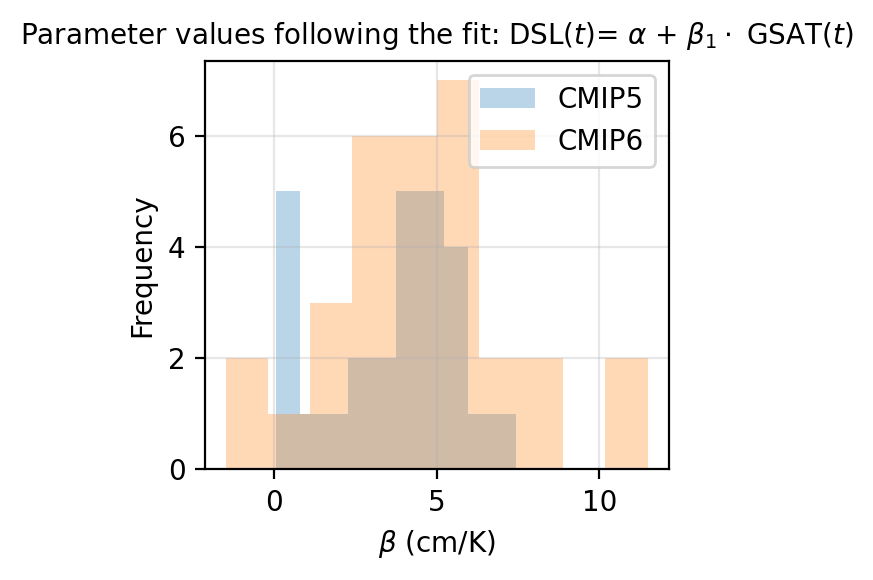

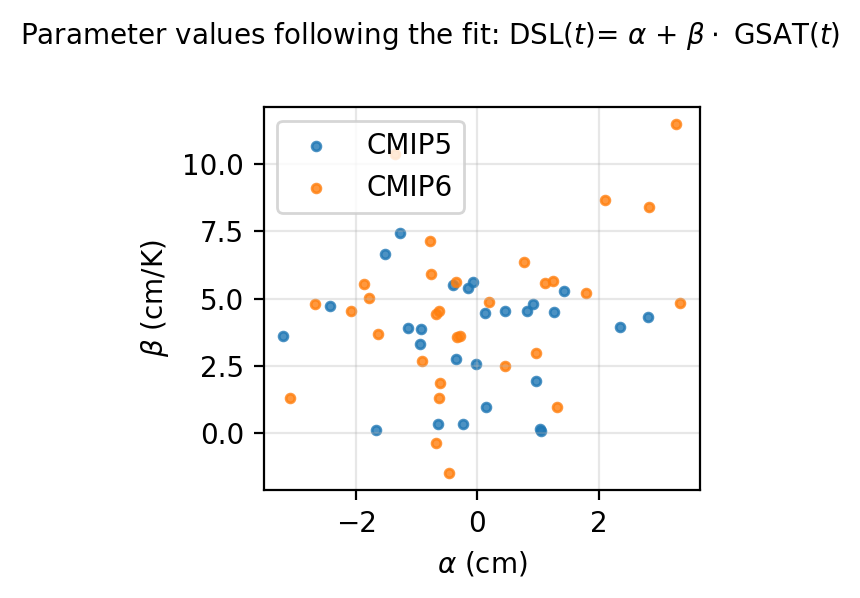

In [249]:
labs = ['CMIP5','CMIP6']

# Frequency Histogram parameter values
fig, ax = plt.subplots(1,1,figsize=(3,3),sharey=True,dpi=dpi)
fig.subplots_adjust(wspace=1/9)

nbins=10
CMIP5_params = df_params5
CMIP6_params = df_params6

for i, pars in enumerate([CMIP5_params, CMIP6_params]):
    ax.hist(pars['beta'],nbins,alpha=0.3,label=labs[i])

    
ax.legend()
ax.set_xlabel(r'$\beta$ (cm/K)')
ax.set_ylabel('Frequency')
ax.grid(True, alpha=0.3)
ax.set_title(r'Parameter values following the fit: DSL$(t)$= $\alpha$ + $\beta_1 \cdot$ GSAT$(t)$', fontsize=10)

fig.tight_layout()
#fig.savefig(savepath+f'Params_hist',dpi=250)


# Scatter plot parameter values
fig, ax = plt.subplots(1,1,figsize=(3,3), dpi=200)
#fig.subplots_adjust(wspace=.1)

for i, pars in enumerate([CMIP5_params, CMIP6_params]):
    ax.scatter(pars['alpha'], pars['beta'], nbins,alpha=0.8,label=labs[i])

ax.legend()
ax.set_xlabel(r'$\alpha$ (cm)')
ax.set_ylabel(r'$\beta$ (cm/K)')
ax.grid(True,alpha=0.3)

fig.suptitle(r'Parameter values following the fit: DSL$(t)$= $\alpha$ + $\beta \cdot$ GSAT$(t)$', fontsize=10);
fig.tight_layout()
#fig.savefig(savepath+f'Params_scat',dpi=250) 

In [250]:
dist5_l = range_to_dist(compute_distr_ensembles(CMIP5ds, 'ssp126','GSAT'), 'x1', 100, 1900, 2100)
dist5_m = range_to_dist(compute_distr_ensembles(CMIP5ds, 'ssp245','GSAT'), 'x1', 100, 1900, 2100)
dist5_h = range_to_dist(compute_distr_ensembles(CMIP5ds, 'ssp585','GSAT'), 'x1', 100, 1900, 2100)

dist6_l = range_to_dist(compute_distr_ensembles(CMIP6ds, 'ssp126','GSAT'), 'x1', 100, 1900, 2100)
dist6_m = range_to_dist(compute_distr_ensembles(CMIP6ds, 'ssp245','GSAT'), 'x1', 100, 1900, 2100)
dist6_h = range_to_dist(compute_distr_ensembles(CMIP6ds, 'ssp585','GSAT'), 'x1', 100, 1900, 2100)

In [251]:
d5l = compute_distr_ensembles(CMIP5ds, 'ssp126','GSAT')
d5m = compute_distr_ensembles(CMIP5ds, 'ssp245','GSAT')
d5h = compute_distr_ensembles(CMIP5ds, 'ssp585','GSAT')

d6l = compute_distr_ensembles(CMIP6ds, 'ssp126','GSAT')
d6m = compute_distr_ensembles(CMIP6ds, 'ssp245','GSAT')
d6h = compute_distr_ensembles(CMIP6ds, 'ssp585','GSAT')

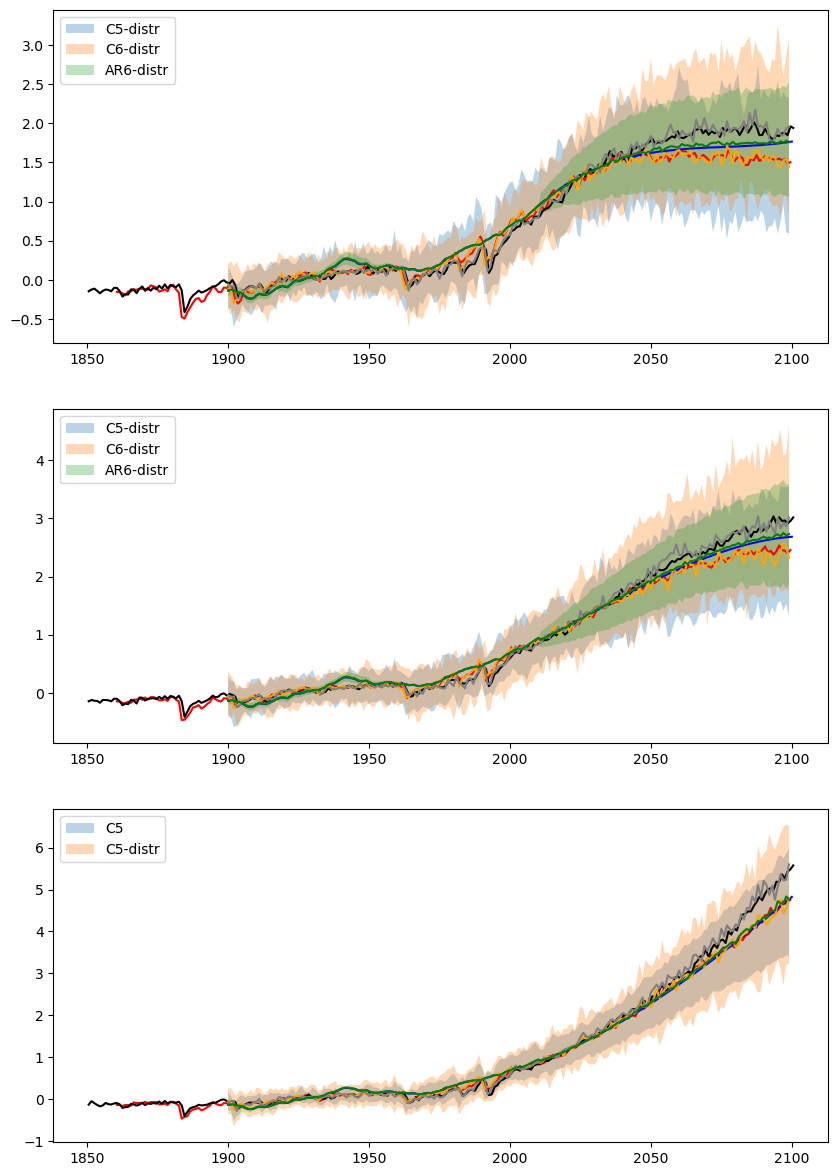

In [252]:
fig,ax = plt.subplots(3,1,figsize=(10,15),dpi=100)
ax[0].plot(CMIP5ds.time.values, CMIP5ds.sel(scenario='ssp126',model=m5_26).GSAT.median(dim='model'),c='r')
ax[0].plot(CMIP6ds.time.values, CMIP6ds.sel(scenario='ssp126',model=m6_26).GSAT.median(dim='model'),c='k')
ax[0].plot(df_low.index, df_low['G_50th'],c='b')
ax[0].plot(np.arange(1900,2100,1), np.median(dist5_l,axis=1),c='orange')
ax[0].plot(np.arange(1900,2100,1), np.median(dist6_l,axis=1),c='grey')
ax[0].plot(np.arange(1900,2100,1), np.median(low_GS,axis=1),c='g')
#ax[0].fill_between(np.arange(1900,2100,1), d5l['x1_5th'],d5l['x1_95th'],alpha=0.3,label='C5')
ax[0].fill_between(np.arange(1900,2100,1), np.percentile(dist5_l,5,axis=1),np.percentile(dist5_l,95,axis=1),alpha=0.3,label='C5-distr')

#ax[0].fill_between(np.arange(1900,2100,1), d6l['x1_5th'],d6l['x1_95th'],alpha=0.3,label='C6')
ax[0].fill_between(np.arange(1900,2100,1), np.percentile(dist6_l,5,axis=1),np.percentile(dist6_l,95,axis=1),alpha=0.3,label='C6-distr')

#ax[0].fill_between(np.arange(1900,2101,1), df_low['G_5th'],df_low['G_95th'],alpha=0.3,label='AR6')
ax[0].fill_between(np.arange(1900,2100,1), np.percentile(low_GS,5,axis=1),np.percentile(low_GS,95,axis=1),alpha=0.3,label='AR6-distr')
ax[0].legend(loc='upper left')



ax[1].plot(CMIP5ds.time.values, CMIP5ds.sel(scenario='ssp245',model=m5_45).GSAT.median(dim='model'),c='r')
ax[1].plot(CMIP6ds.time.values, CMIP6ds.sel(scenario='ssp245',model=m6_45).GSAT.median(dim='model'),c='k')
ax[1].plot(df_mid.index, df_mid['G_50th'],c='b')
ax[1].plot(np.arange(1900,2100,1), np.median(dist5_m,axis=1),c='orange')
ax[1].plot(np.arange(1900,2100,1), np.median(dist6_m,axis=1),c='grey')
ax[1].plot(np.arange(1900,2100,1), np.median(mid_GS,axis=1),c='g')

#ax[1].fill_between(np.arange(1900,2100,1), d5m['x1_5th'],d5m['x1_95th'],alpha=0.3,label='C5')
ax[1].fill_between(np.arange(1900,2100,1), np.percentile(dist5_m,5,axis=1),np.percentile(dist5_m,95,axis=1),alpha=0.3,label='C5-distr')

#ax[1].fill_between(np.arange(1900,2100,1), d6m['x1_5th'],d6m['x1_95th'],alpha=0.3,label='C6')
ax[1].fill_between(np.arange(1900,2100,1), np.percentile(dist6_m,5,axis=1),np.percentile(dist6_m,95,axis=1),alpha=0.3,label='C6-distr')

#ax[1].fill_between(np.arange(1900,2101,1), df_mid['G_5th'],df_mid['G_95th'],alpha=0.3,label='AR6')
ax[1].fill_between(np.arange(1900,2100,1), np.percentile(mid_GS,5,axis=1),np.percentile(mid_GS,95,axis=1),alpha=0.3,label='AR6-distr')
ax[1].legend(loc='upper left')


ax[2].plot(CMIP5ds.time.values, CMIP5ds.sel(scenario='ssp585',model=m5_85).GSAT.median(dim='model'),c='r')
ax[2].plot(CMIP6ds.time.values, CMIP6ds.sel(scenario='ssp585',model=m6_85).GSAT.median(dim='model'),c='k')
ax[2].plot(df_hig.index, df_hig['G_50th'],c='b')
ax[2].plot(np.arange(1900,2100,1), np.median(dist5_h,axis=1),c='orange')
ax[2].plot(np.arange(1900,2100,1), np.median(dist6_h,axis=1),c='grey')
ax[2].plot(np.arange(1900,2100,1), np.median(hig_GS,axis=1),c='g')

ax[2].fill_between(np.arange(1900,2100,1), d5h['x1_5th'],d5h['x1_95th'],alpha=0.3,label='C5')
ax[2].fill_between(np.arange(1900,2100,1), np.percentile(dist5_h,5,axis=1),np.percentile(dist5_h,95,axis=1),alpha=0.3,label='C5-distr')

#ax[2].fill_between(np.arange(1900,2100,1), d6h['x1_5th'],d6h['x1_95th'],alpha=0.3,label='C6')
#ax[2].fill_between(np.arange(1900,2100,1), np.percentile(dist6_h,5,axis=1),np.percentile(dist6_h,95,axis=1),alpha=0.3,label='C6-distr')

#ax[2].fill_between(np.arange(1900,2101,1), df_hig['G_5th'],df_hig['G_95th'],alpha=0.3,label='AR6')
#ax[2].fill_between(np.arange(1900,2100,1), np.percentile(hig_GS,5,axis=1),np.percentile(hig_GS,95,axis=1),alpha=0.3,label='AR6-distr')
ax[2].legend(loc='upper left')

In [253]:
def compute_DSLs(mip, sce, CMIP5_params, CMIP6_params, samples, x1_distrs, dep):
    
    if sce == 'ssp126' or sce =='rcp26':
        sce_index = 0
    elif sce == 'ssp245' or sce =='rcp45':
        sce_index = 1
    elif sce == 'ssp585' or sce =='rcp85':
        sce_index = 2
    
    if mip == 'cmip5':
        paramsets = CMIP5_params[sce_index]
    elif mip == 'cmip6':
        paramsets = CMIP6_params[sce_index]
        
    # Create arrays in which we store random_params and 
    random_params = np.zeros([samples,2])
    DSL = np.zeros(199)
    DSLs = np.zeros([samples,199])
    
    # Loop over the number of samples you want to take
    for j in range(0, samples):
        # Select a random set of alpha, beta, gamma, linear dependence: zostoga(GSAT) = a1 + a0 * GSAT
        random = paramsets.sample()
        random_params[j] = random['alpha'], random['beta']#, random['a0'], random['a1']

        dist_x1 = np.random.choice(np.arange(0,len(x1_distrs[0])))
        #print(dist_x1)
        if dep == 'none':
            

            for i in range(0,199):
                x1_val = x1_distrs[i][dist_x1]
                #print(x1_val)
                DSL[i] = random_params[j][0] + x1_val * random_params[j][1] 
                
                
        # Loop over all time steps using these parameter sets and GSAT-zostoga paths, start in 2020
        DSLs[j] = DSL
    
    #print(np.median(zt_vals))
    
    return DSLs

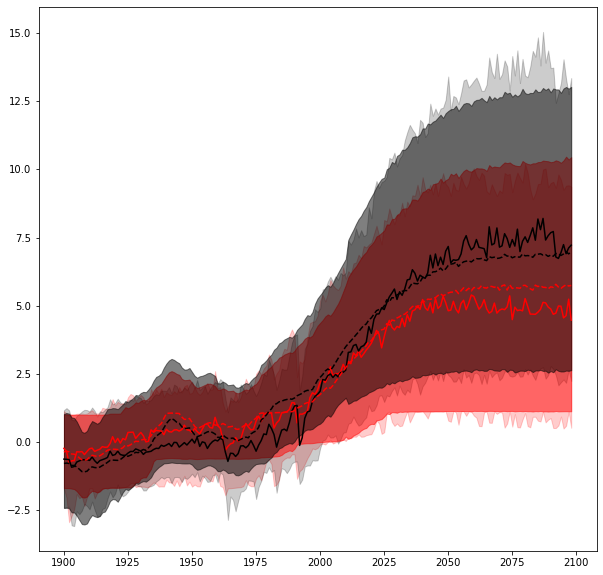

In [259]:
scenar = 'ssp126'

a5 = compute_DSLs('cmip5', scenar, CMIP5_parameters, CMIP6_parameters, 1000, dist5_l, 'none')
a6 = compute_DSLs('cmip6', scenar, CMIP5_parameters, CMIP6_parameters, 1000, dist6_l, 'none')
ar5 = compute_DSLs('cmip5', scenar, CMIP5_parameters, CMIP6_parameters, 1000, low_GS, 'none')
ar6 = compute_DSLs('cmip6', scenar, CMIP5_parameters, CMIP6_parameters, 1000, low_GS, 'none')

fig,ax = plt.subplots(1,1,figsize=(10,10))
ax.plot(np.arange(1900,2099,1),np.median(a5,axis=0),c='r')
ax.plot(np.arange(1900,2099,1),np.median(a6,axis=0),c='k')
ax.plot(np.arange(1900,2099,1),np.median(ar5,axis=0),c='r',ls='dashed')
ax.plot(np.arange(1900,2099,1),np.median(ar6,axis=0),c='k',ls='dashed')

ax.fill_between(np.arange(1900,2099,1),np.percentile(a5,17,axis=0),np.percentile(a5,83,axis=0),alpha=0.2,color='r')
ax.fill_between(np.arange(1900,2099,1),np.percentile(a6,17,axis=0),np.percentile(a6,83,axis=0),alpha=0.2,color='k')
ax.fill_between(np.arange(1900,2099,1),np.percentile(ar5,17,axis=0),np.percentile(ar5,83,axis=0),alpha=0.5,color='r')
ax.fill_between(np.arange(1900,2099,1),np.percentile(ar6,17,axis=0),np.percentile(ar6,83,axis=0),alpha=0.5,color='k')
#ax.fill_between(np.arange(1900,2100,1),np.percentile(a5,5),np.percentile(a5,95))


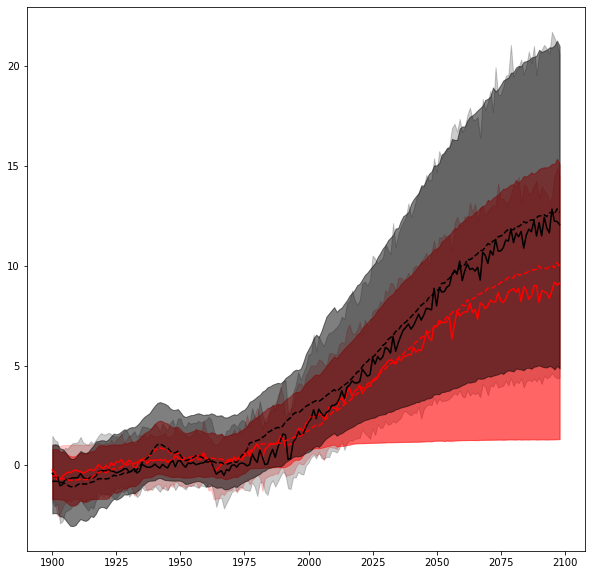

In [258]:
scenar = 'ssp245'

a5 = compute_DSLs('cmip5', scenar, CMIP5_parameters, CMIP6_parameters, 1000, dist5_m, 'none')
a6 = compute_DSLs('cmip6', scenar, CMIP5_parameters, CMIP6_parameters, 1000, dist6_m, 'none')
ar5 = compute_DSLs('cmip5', scenar, CMIP5_parameters, CMIP6_parameters, 1000, mid_GS, 'none')
ar6 = compute_DSLs('cmip6', scenar, CMIP5_parameters, CMIP6_parameters, 1000, mid_GS, 'none')

fig,ax = plt.subplots(1,1,figsize=(10,10))
ax.plot(np.arange(1900,2099,1),np.median(a5,axis=0),c='r')
ax.plot(np.arange(1900,2099,1),np.median(a6,axis=0),c='k')
ax.plot(np.arange(1900,2099,1),np.median(ar5,axis=0),c='r',ls='dashed')
ax.plot(np.arange(1900,2099,1),np.median(ar6,axis=0),c='k',ls='dashed')

ax.fill_between(np.arange(1900,2099,1),np.percentile(a5,17,axis=0),np.percentile(a5,83,axis=0),alpha=0.2,color='r')
ax.fill_between(np.arange(1900,2099,1),np.percentile(a6,17,axis=0),np.percentile(a6,83,axis=0),alpha=0.2,color='k')
ax.fill_between(np.arange(1900,2099,1),np.percentile(ar5,17,axis=0),np.percentile(ar5,83,axis=0),alpha=0.5,color='r')
ax.fill_between(np.arange(1900,2099,1),np.percentile(ar6,17,axis=0),np.percentile(ar6,83,axis=0),alpha=0.5,color='k')

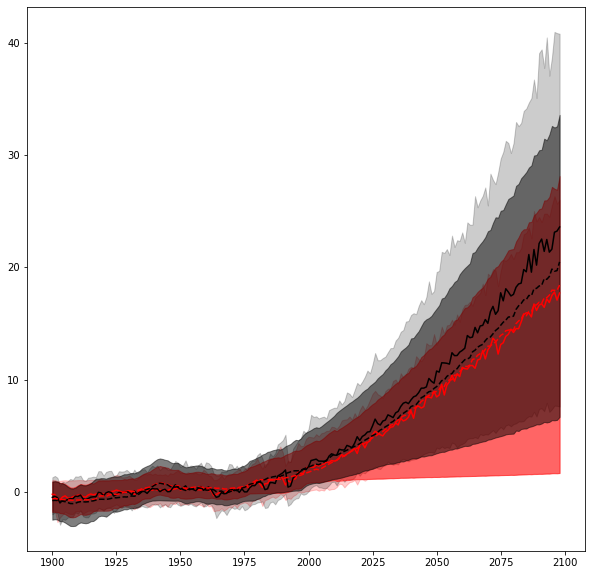

In [257]:
scenar = 'ssp585'

a5 = compute_DSLs('cmip5', scenar, CMIP5_parameters, CMIP6_parameters, 1000, dist5_h, 'none')
a6 = compute_DSLs('cmip6', scenar, CMIP5_parameters, CMIP6_parameters, 1000, dist6_h, 'none')
ar5 = compute_DSLs('cmip5', scenar, CMIP5_parameters, CMIP6_parameters, 1000, hig_GS, 'none')
ar6 = compute_DSLs('cmip6', scenar, CMIP5_parameters, CMIP6_parameters, 1000, hig_GS, 'none')

fig,ax = plt.subplots(1,1,figsize=(10,10))
ax.plot(np.arange(1900,2099,1),np.median(a5,axis=0),c='r')
ax.plot(np.arange(1900,2099,1),np.median(a6,axis=0),c='k')
ax.plot(np.arange(1900,2099,1),np.median(ar5,axis=0),c='r',ls='dashed')
ax.plot(np.arange(1900,2099,1),np.median(ar6,axis=0),c='k',ls='dashed')

ax.fill_between(np.arange(1900,2099,1),np.percentile(a5,17,axis=0),np.percentile(a5,83,axis=0),alpha=0.2,color='r')
ax.fill_between(np.arange(1900,2099,1),np.percentile(a6,17,axis=0),np.percentile(a6,83,axis=0),alpha=0.2,color='k')
ax.fill_between(np.arange(1900,2099,1),np.percentile(ar5,17,axis=0),np.percentile(ar5,83,axis=0),alpha=0.5,color='r')
ax.fill_between(np.arange(1900,2099,1),np.percentile(ar6,17,axis=0),np.percentile(ar6,83,axis=0),alpha=0.5,color='k')

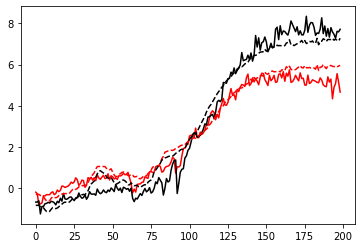

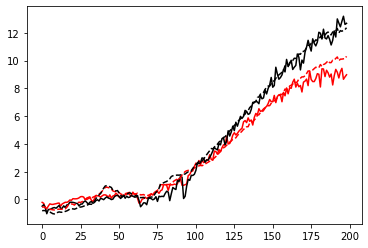

In [110]:
plt.plot(np.median(a5,axis=0),c='r')
plt.plot(np.median(a6,axis=0),c='k')
plt.plot(np.median(ar5,axis=0),c='r',ls='dashed')
plt.plot(np.median(ar6,axis=0),c='k',ls='dashed')

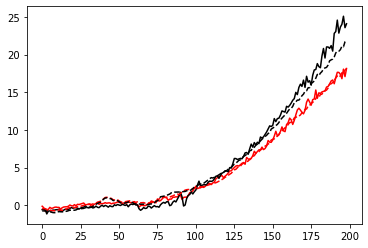

In [106]:
plt.plot(np.median(a5,axis=0),c='r')
plt.plot(np.median(a6,axis=0),c='k')
plt.plot(np.median(ar5,axis=0),c='r',ls='dashed')
plt.plot(np.median(ar6,axis=0),c='k',ls='dashed')

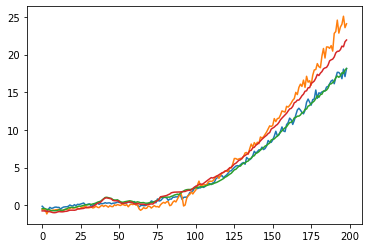

In [105]:
plt.plot(np.median(a5,axis=0))
plt.plot(np.median(a6,axis=0))
plt.plot(np.median(ar5,axis=0))
plt.plot(np.median(ar6,axis=0))

In [ ]:
fig, ax = plt.subplots(2,1,figsize=(10,10))

ax[0].set_title('GSAT')
ax[0].plot(np.median(dist6645,axis=1))
ax[0].fill_between(np.arange(1900,2100,1),np.percentile(dist6645,5,axis=1),np.percentile(dist6645,95,axis=1),alpha=0.2)

ax[0].plot(dist6_45['x1_50th'])
ax[0].fill_between(dist6_45.index, dist6_45['x1_5th'], dist6_45['x1_95th'],alpha=0.2)
ax[0].grid(True)
ax[0].set_xlim([1900,2100])
ax[0].set_ylim([-1,4])

ax[1].set_title('AMOC')
#ax[1].plot(dist6_45['z_50th'])
#ax[1].fill_between(dist6_45.index, dist6_45['z_5th'], dist6_45['z_95th'],alpha=0.2)
ax[1].grid(True)
ax[1].set_xlim([1900,2100])
ax[1].set_ylim([-12,4])

In [ ]:
fig, ax = plt.subplots(2,1,figsize=(10,10))

ax[0].set_title('GSAT')
ax[0].plot(np.median(dist6645,axis=1))
ax[0].fill_between(np.arange(1900,2100,1),np.percentile(dist6645,5,axis=1),np.percentile(dist6645,95,axis=1),alpha=0.2)

ax[0].plot(dist6_45['x1_50th'])
ax[0].fill_between(dist6_45.index, dist6_45['x1_5th'], dist6_45['x1_95th'],alpha=0.2)
ax[0].grid(True)
ax[0].set_xlim([1900,2100])
ax[0].set_ylim([-1,4])

ax[1].set_title('AMOC')
#ax[1].plot(dist6_45['z_50th'])
#ax[1].fill_between(dist6_45.index, dist6_45['z_5th'], dist6_45['z_95th'],alpha=0.2)
ax[1].grid(True)
ax[1].set_xlim([1900,2100])
ax[1].set_ylim([-12,4])

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(10,5))

ax.set_title('GSAT - via distrs')
ax.plot(dist6_45['G_50th'])
ax.fill_between(dist6_45.index, dist6_45['G_5th'], dist6_45['G_95th'],alpha=0.2,label='from CMIP')
ax.plot(dist6_45.index[:-1], meds)
ax.fill_between(dist6_45.index[:-1], th5s, th95s, alpha=0.2,label='distrs')
ax.legend(loc='upper left')
ax.grid(True)
ax.set_xlim([1900,2100])
#ax.set_ylim([-1,4]);

In [ ]:
func_cdf = stats.lognorm # stats.gamma, stats.weibull_min , stats.skewnorm, stats.genextreme, stats.lognorm
pc = np.array([5,50,95])*0.01

def func(x, a, scale):
    return func_cdf.cdf(x, a, iloc, scale)

def range_to_dist(df, var, n, st_yr, end_yr):
    '''
    INPUT:
        - df: dataframe as above
        - var: either 'GSAT' or 'zostoga'
        - pc: percentiles: ea [5, 50, 95]
        - n: number of samples you want to generate
    OUTPUT:
        - random distribution with n values
    '''
    distrs = []
    func_cdf = stats.lognorm

    for i in range(st_yr,end_yr+1):
        yr = i
        
        if var == 'GSAT':
            data_sel = df.loc[yr][0:3]
            pc = np.array([5,50,95])*0.01
            
        elif var == 'zostoga':
            data_sel = df.loc[yr][3:6]
            pc = np.array([5,50,95])*0.01

        iloc = data_sel[0]-0.05+10
        popt, pcov = curve_fit(func, data_sel, pc)
        err = np.square(func(data_sel.astype(float), popt[0], popt[1]) - pc).mean()
    
        # Calculate mean and std for probability function
        mean = func_cdf.mean(popt[0], iloc, popt[1])
        std = func_cdf.std(popt[0], iloc, popt[1])
        
        # Translate to mu and sigma
        mu = np.log(mean**2/np.sqrt(mean**2+std**2))
        sigma = np.sqrt(np.log(1+(std**2/mean**2)))
        
        # Sample n values from distribution and store in array
        distr = np.random.lognormal(mu, sigma, n)
        distr = np.sort(distr)
        
        # Save distribution to array
        distrs.append(distr)
        
    return distrs

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(10,5))

ax.set_title('GSAT - via distrs')
ax.plot(dist6_45['G_50th'])
ax.fill_between(dist6_45.index, dist6_45['G_5th'], dist6_45['G_95th'],alpha=0.2,label='from CMIP')
ax.plot(dist6_45.index[:-1], meds)
ax.fill_between(dist6_45.index[:-1], th5s, th95s, alpha=0.2,label='distrs')
ax.legend(loc='upper left')
ax.grid(True)
ax.set_xlim([1900,2100])
#ax.set_ylim([-1,4]);

#### Conclusion from plot above:
Distributions do not represent the actual percentile scores well.

print(f'median = {np.median(a[150]):.2f}')
print(f'5th = {np.percentile(a[150],5):.2f}')
print(f'95th = {np.percentile(a[150],95):.2f}')

plt.hist(a[150],100);



def func(x, a, scale):
    func_cdf = stats.lognorm
    iloc = -20

    return func_cdf.cdf(x, a, iloc, scale)

def range_to_dist(df, var, n, st_yr, end_yr):
    '''
    INPUT:
        - df: dataframe as above
        - var: either 'GSAT' or 'zostoga'
        - pc: percentiles: ea [5, 50, 95]
        - n: number of samples you want to generate
    OUTPUT:
        - random distribution with n values
    '''
    distrs = []
    func_cdf = stats.lognorm

    for i in range(st_yr,end_yr+1):
        yr = i
        
        if var == 'GSAT':
            data_sel = df.loc[yr][0:3]
            pc = np.array([5,50,95])*0.01
            
        elif var == 'zostoga':
            data_sel = df.loc[yr][3:6]
            pc = np.array([5,50,95])*0.01

        iloc = -20
        popt, pcov = curve_fit(func, data_sel, pc)
        err = np.square(func(data_sel.astype(float), popt[0], popt[1]) - pc).mean()
    
        # Calculate mean and std for probability function
        mean = func_cdf.mean(popt[0], iloc, popt[1])
        std = func_cdf.std(popt[0], iloc, popt[1])
        
        # Translate to mu and sigma
        mu = np.log(mean**2/np.sqrt(mean**2+std**2))
        sigma = np.sqrt(np.log(1+(std**2/mean**2)))
        
        mu = np.log(mean**2/np.sqrt(mean**2+std**2))
        sigma = np.sqrt(np.log(1+(std**2/mean**2)))
    
        # Sample n values from distribution and store in array
        distr = np.random.lognormal(mu, sigma, n)
        distr = np.sort(distr)
        
        # Save distribution to array
        distrs.append(distr)
        
    return distrs